# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [475]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto(device_count={'CPU' : 1, 'GPU' : 1},allow_soft_placement=True,log_device_placement=True)
    #config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


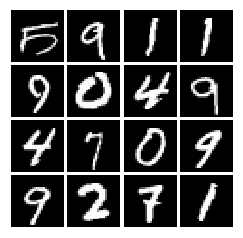

In [690]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [477]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    lx = tf.maximum(x, alpha * x)
    return lx


Test your leaky ReLU implementation. You should get errors < 1e-10

In [478]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [691]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    rt = tf.random_uniform((batch_size,dim),minval=-1, maxval=1)     
    return rt

Make sure noise is the correct shape and type:

In [692]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [481]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        #W1 = tf.get_variable("W1", shape=[784,256])
        #b1 = tf.get_variable("b1", shape=[ 256])
        #W2 = tf.get_variable("W2", shape = [256,256])
        #b2 = tf.get_variable("b1", shape=[256])
        #W3 = tf.get_variable("W3", shape=[256,1])
        #b1 = tf.get_variable("b3", shape = [1])
        # TODO: implement architecture  

        a1 = tf.layers.dense(inputs=x,units=256,use_bias=True)
        a1l = leaky_relu(a1,alpha=0.01)
        a2 = tf.layers.dense(inputs=a1l,units=256,use_bias=True)
        a2l = leaky_relu(a2,alpha=0.01)
        logits = tf.layers.dense(inputs=a2l,units=1,use_bias=True)
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [482]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [483]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        a1 = tf.layers.dense(inputs=z,units=1024,use_bias=True)
        a1l = leaky_relu(a1,alpha=0.01)
        a2 = tf.layers.dense(inputs=a1l,units=1024,use_bias=True)
        a2l = leaky_relu(a2,alpha=0.01)
        a3 = tf.layers.dense(inputs=a2l,units=784,use_bias=True)
        img = tf.tanh(a3)
        return img

Test to make sure the number of parameters in the generator is correct:

In [484]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [485]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    
    # Using sigmoid as a trick to compute log prob for "true" class, assuming the 
    #score for the "other" class is 0 (hence: exp(0) = 1, the "1" is provided by the 
    # sigmoid denominator)
    
    label0 = tf.zeros_like(logits_fake)
    label1 = tf.ones_like(logits_real)
    ones = tf.ones_like(logits_real)
    
    #  sigmoid_cross_entropy_with_logits with label=1: computes -log(sigmoid(x)), for fake x
    lg_a = tf.nn.sigmoid_cross_entropy_with_logits(labels=label1,logits=logits_fake) 
    # want to minimize the delta between fake "positives" and 1  (== good generator)
    
    #  sigmoid_cross_entropy_with_logits with label=1: computes -log(sigmoid(x)), for real x
    ld_a = (tf.nn.sigmoid_cross_entropy_with_logits(labels=label1,logits=logits_real))
    # want to minimize the delat between real "positives" and 1 (== good Discriminator)
 
    #  sigmoid_cross_entropy_with_logits with label=0: computes -log(1- sigmoid(x)), for fake x
    ld_b = (tf.nn.sigmoid_cross_entropy_with_logits(labels=label0,logits=logits_fake) )
    # want to minimize the delat between fake "positives" and 0 (== good Discriminator)

    
    D_loss= tf.reduce_mean(ld_a + ld_b)
    G_loss =   tf.reduce_mean(lg_a)

    
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [486]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
         d_loss, g_loss  = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))
 
 
test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [487]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    lr_var = tf.Variable(learning_rate, name="lr")
    beta1_var = tf.Variable(beta1, name="beta1")
    #D_solver = tf.train.AdamOptimizer(lr_var, beta1_var,name='discriminator') 
    #G_solver = tf.train.AdamOptimizer(lr_var, beta1_var,name='generator')
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [488]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784] )
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)
    kz = tf.Variable(tf.zeros((batch_size, noise_dim), tf.float32))

    
# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [489]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128 , num_epoch=5):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    D_loss_history = []
    G_loss_history = []
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
       
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
      
        _, G_loss_curr = sess.run([G_train_step, G_loss],feed_dict={x: minibatch})
      
        #log the loss history
        D_loss_history.append(D_loss_curr)
        G_loss_history.append(G_loss_curr)
        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    saver = tf.train.Saver()
    save_path = saver.save(sess, "/tmp/model.ckpt")
    print("Model saved in file: %s" % save_path)
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()
    return (D_loss_history, G_loss_history)

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

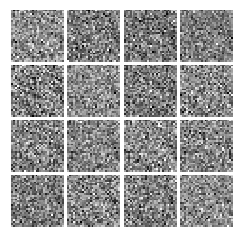


Iter: 0, D: 1.217, G:0.7364
Iter: 50, D: 1.433, G:1.752
Iter: 100, D: 1.19, G:1.539
Iter: 150, D: 1.071, G:0.8431
Iter: 200, D: 0.9138, G:1.714


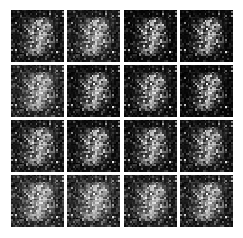


Iter: 250, D: 1.406, G:1.073
Iter: 300, D: 1.335, G:1.113
Iter: 350, D: 0.876, G:1.855
Iter: 400, D: 0.9245, G:2.726
Iter: 450, D: 0.7813, G:1.214


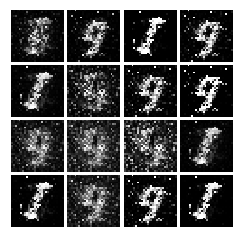


Iter: 500, D: 1.456, G:3.333
Iter: 550, D: 0.8884, G:1.422
Iter: 600, D: 1.032, G:1.47
Iter: 650, D: 1.127, G:1.039
Iter: 700, D: 1.436, G:1.601


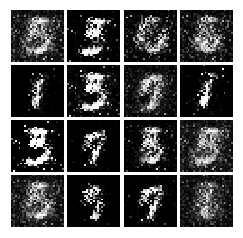


Iter: 750, D: 1.019, G:1.038
Iter: 800, D: 1.14, G:0.9129
Iter: 850, D: 0.9997, G:1.469
Iter: 900, D: 1.135, G:0.991
Iter: 950, D: 1.132, G:1.021


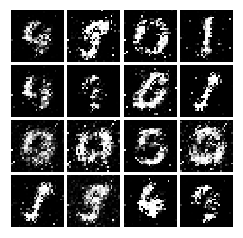


Iter: 1000, D: 1.242, G:0.7314
Iter: 1050, D: 1.365, G:1.059
Iter: 1100, D: 1.092, G:1.335
Iter: 1150, D: 1.152, G:1.063
Iter: 1200, D: 1.086, G:1.621


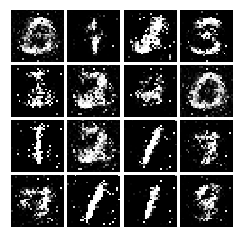


Iter: 1250, D: 1.23, G:1.105
Iter: 1300, D: 1.299, G:0.8912
Iter: 1350, D: 1.232, G:0.8762
Iter: 1400, D: 1.314, G:1.005
Iter: 1450, D: 1.248, G:0.9558


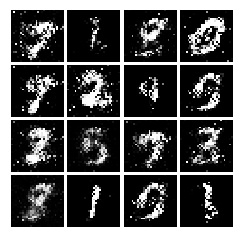


Iter: 1500, D: 1.287, G:0.9198
Iter: 1550, D: 1.328, G:1.179
Iter: 1600, D: 1.318, G:0.8748
Iter: 1650, D: 1.325, G:0.9312
Iter: 1700, D: 1.175, G:1.045


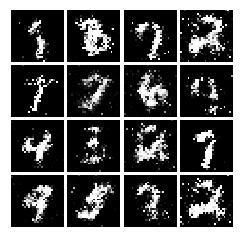


Iter: 1750, D: 1.277, G:0.9534
Iter: 1800, D: 1.334, G:0.7773
Iter: 1850, D: 1.272, G:0.934
Iter: 1900, D: 1.308, G:0.8572
Iter: 1950, D: 1.214, G:0.9104


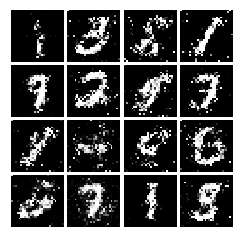


Iter: 2000, D: 1.238, G:0.928
Iter: 2050, D: 1.372, G:0.9915
Iter: 2100, D: 1.37, G:0.9513
Model saved in file: /tmp/model.ckpt
Final images


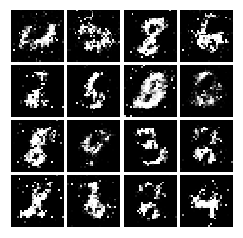

In [490]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    Dloss, Gloss = run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

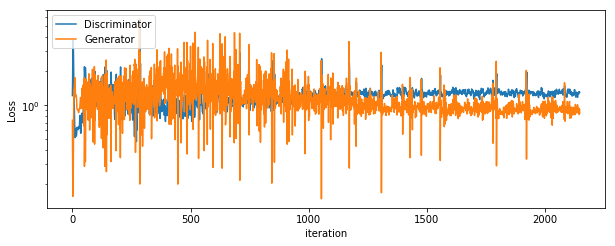

In [491]:


#Dloss_new = list(Dloss)
#Dloss_new = [1 * i for i in Dloss_new]

plt.subplot(2, 1, 2)
plt.plot(Dloss )
plt.plot(Gloss)
plt.legend(['Discriminator', 'Generator'], loc='upper left')
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.show()

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [492]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
     
    
    # TODO: compute D_loss and G_loss
    D_loss_a = 0.5 * tf.reduce_mean(tf.squared_difference(score_real,1)) 
    D_loss_b = 0.5 * tf.reduce_mean(tf.square(score_fake)) 

    D_loss = D_loss_a + D_loss_b
    G_loss = 0.5 * tf.reduce_mean(tf.squared_difference(score_fake,1))
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [493]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [494]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

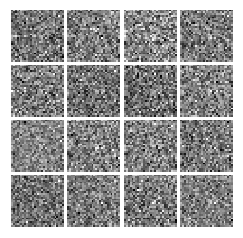


Iter: 0, D: 0.06448, G:0.4865
Iter: 50, D: 0.01523, G:0.7644
Iter: 100, D: 0.06495, G:0.7411
Iter: 150, D: 0.2066, G:0.5133
Iter: 200, D: 0.1221, G:0.5207


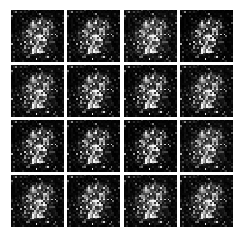


Iter: 250, D: 0.112, G:0.3358
Iter: 300, D: 0.07435, G:0.3892
Iter: 350, D: 0.05401, G:0.4758
Iter: 400, D: 0.2002, G:0.1252
Iter: 450, D: 0.1485, G:0.4166


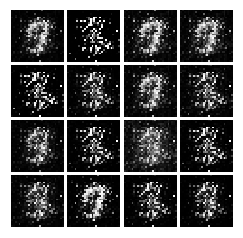


Iter: 500, D: 0.06086, G:0.4481
Iter: 550, D: 0.09197, G:0.3506
Iter: 600, D: 0.08258, G:0.4833
Iter: 650, D: 0.05026, G:0.6782
Iter: 700, D: 0.1553, G:0.452


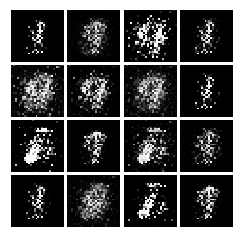


Iter: 750, D: 0.1483, G:0.278
Iter: 800, D: 0.1854, G:0.3127
Iter: 850, D: 0.6652, G:0.1874
Iter: 900, D: 0.1615, G:0.2607
Iter: 950, D: 0.2077, G:0.2821


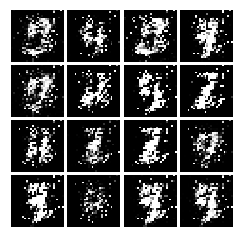


Iter: 1000, D: 0.12, G:0.4736
Iter: 1050, D: 0.1808, G:0.3091
Iter: 1100, D: 0.1871, G:0.2399
Iter: 1150, D: 0.1589, G:0.2785
Iter: 1200, D: 0.1239, G:0.3662


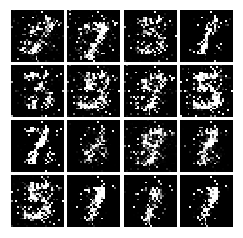


Iter: 1250, D: 0.1452, G:0.3036
Iter: 1300, D: 0.1777, G:0.2567
Iter: 1350, D: 0.1354, G:0.386
Iter: 1400, D: 0.199, G:0.509
Iter: 1450, D: 0.151, G:0.2683


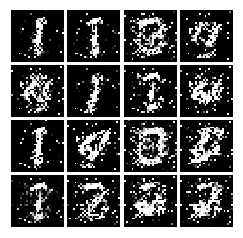


Iter: 1500, D: 0.1774, G:0.2982
Iter: 1550, D: 0.1518, G:0.2911
Iter: 1600, D: 0.2058, G:0.2316
Iter: 1650, D: 0.1891, G:0.2154
Iter: 1700, D: 0.2214, G:0.2827


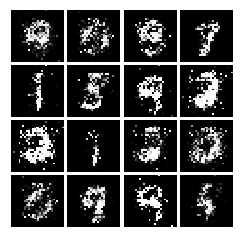


Iter: 1750, D: 0.2001, G:0.2283
Iter: 1800, D: 0.2364, G:0.1965
Iter: 1850, D: 0.1934, G:0.2229
Iter: 1900, D: 0.192, G:0.2276
Iter: 1950, D: 0.2387, G:0.2451


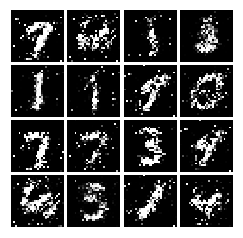


Iter: 2000, D: 0.1803, G:0.2372
Iter: 2050, D: 0.2189, G:0.2083
Iter: 2100, D: 0.2278, G:0.1745
Model saved in file: /tmp/model.ckpt
Final images


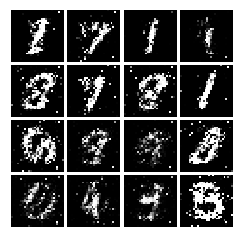

In [495]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    Dloss, Gloss = run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

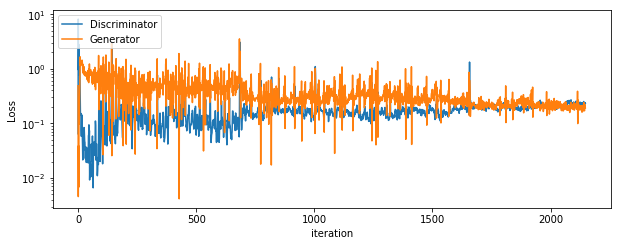

In [496]:
# Visualize loss
plt.subplot(2, 1, 2)
plt.plot(Dloss )
plt.plot(Gloss)
plt.legend(['Discriminator', 'Generator'], loc='upper left')
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.show()

In [497]:
with get_session() as sess:
    samples = sess.run(G_sample)
    fig = show_images(samples[:16])
    plt.show()

FailedPreconditionError: Attempting to use uninitialized value generator/dense/kernel
	 [[Node: generator/dense/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@generator/dense/kernel"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](generator/dense/kernel)]]
	 [[Node: generator/Tanh/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_45_generator/Tanh", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'generator/dense/kernel/read', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-488-e24f0524daa5>", line 13, in <module>
    G_sample = generator(z)
  File "<ipython-input-483-b0815bc4382a>", line 12, in generator
    a1 = tf.layers.dense(inputs=z,units=1024,use_bias=True)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tensorflow/python/layers/core.py", line 250, in dense
    return layer.apply(inputs)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 671, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 559, in __call__
    self.build(input_shapes[0])
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tensorflow/python/layers/core.py", line 137, in build
    trainable=True)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 458, in add_variable
    trainable=trainable and self.trainable)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 1203, in get_variable
    constraint=constraint)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 1092, in get_variable
    constraint=constraint)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 425, in get_variable
    constraint=constraint)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 394, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 805, in _get_single_variable
    constraint=constraint)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 356, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 125, in identity
    return gen_array_ops.identity(input, name=name)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2071, in identity
    "Identity", input=input, name=name)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/arieb/Study/CS231n/assignment2/.env/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value generator/dense/kernel
	 [[Node: generator/dense/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@generator/dense/kernel"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](generator/dense/kernel)]]
	 [[Node: generator/Tanh/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_45_generator/Tanh", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

Slowly improving, but noisy till end

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [498]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        # inpu reshape layer
        input_layer = tf.reshape(x,[-1,28,28,1])
        conv1 = tf.layers.conv2d(input_layer,filters=32,kernel_size=[5,5],padding="valid")
        conv1l = leaky_relu(conv1,alpha=0.01)
        pool1 = tf.layers.max_pooling2d(conv1l,pool_size=[2,2],strides=2)
        conv2 = tf.layers.conv2d(pool1,filters=64,kernel_size=[5,5],padding="valid")
        conv2l = leaky_relu(conv2,alpha= 0.01)
        pool2 = tf.layers.max_pooling2d(conv2l,pool_size=[2,2],strides=2) 
        pool2_f =tf.reshape(pool2,[-1,4*4*64])    #3136
        fc1 = tf.layers.dense(inputs=pool2_f,units=4*4*64,use_bias=True)
        fc1l = leaky_relu(fc1,alpha=0.01)
        logits = tf.layers.dense(inputs=fc1l,units=1,use_bias=True)
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [499]:
def generator(z, is_training=True):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        fc1 = tf.layers.dense(inputs=z,units=1024,activation=tf.nn.relu,use_bias=True)
        fc1b = tf.layers.batch_normalization(fc1,axis=-1,training=is_training)
        fc2 = tf.layers.dense(inputs=fc1b,units=7*7*128,activation=tf.nn.relu,use_bias=True)
        fc2b = tf.layers.batch_normalization(fc2,axis=-1,training=is_training)
        fc2c = tf.reshape(fc2b,[-1,7,7,128])
        dc1 = tf.layers.conv2d_transpose(fc2c,filters=64,kernel_size=[4,4],strides=(2,2),\
                                         activation=tf.nn.relu ,padding='same')
        dc1b = tf.layers.batch_normalization(dc1,axis=-1,training=is_training)
        
        dc2 =  tf.layers.conv2d_transpose(dc1b,filters=1,kernel_size=[4,4],strides=(2,2),\
                                         activation=tf.nn.tanh,padding='same')         
        img = tf.reshape(dc2,[-1,784])
        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [500]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)
kz = tf.Variable(tf.zeros((batch_size, noise_dim), tf.float32))

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

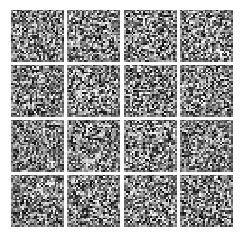


Iter: 0, D: 1.358, G:1.056
Iter: 50, D: 0.4847, G:0.02125
Iter: 100, D: 4.122, G:0.1476
Iter: 150, D: 1.002, G:1.436
Iter: 200, D: 0.8256, G:1.215


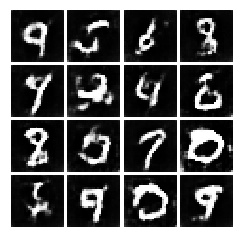


Iter: 250, D: 0.9237, G:1.31
Iter: 300, D: 0.9577, G:1.1
Iter: 350, D: 1.032, G:1.037
Iter: 400, D: 1.374, G:0.6147
Iter: 450, D: 1.037, G:1.071


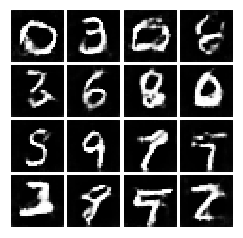


Iter: 500, D: 1.1, G:0.695
Iter: 550, D: 1.129, G:0.8239
Iter: 600, D: 1.076, G:0.967
Iter: 650, D: 1.064, G:0.9445
Iter: 700, D: 1.335, G:0.8813


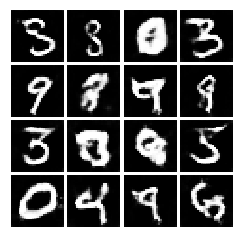


Iter: 750, D: 1.178, G:0.5893
Iter: 800, D: 1.116, G:1.199
Iter: 850, D: 1.239, G:1.211
Iter: 900, D: 1.101, G:1.014
Iter: 950, D: 1.227, G:0.6805


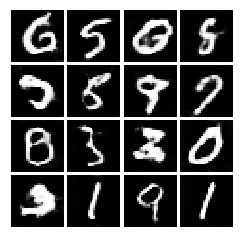


Iter: 1000, D: 1.189, G:0.7775
Iter: 1050, D: 1.093, G:0.9309
Iter: 1100, D: 1.166, G:1.157
Iter: 1150, D: 1.212, G:1.462
Iter: 1200, D: 1.213, G:1.086


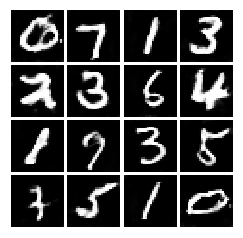


Iter: 1250, D: 1.154, G:0.9961
Iter: 1300, D: 1.255, G:0.9033
Iter: 1350, D: 1.377, G:1.047
Iter: 1400, D: 1.458, G:0.7522
Iter: 1450, D: 1.145, G:1.129


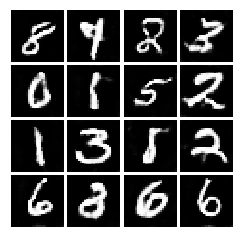


Iter: 1500, D: 1.251, G:0.853
Iter: 1550, D: 1.124, G:0.87
Iter: 1600, D: 1.216, G:1.204
Iter: 1650, D: 1.212, G:1.505
Iter: 1700, D: 1.305, G:1.607


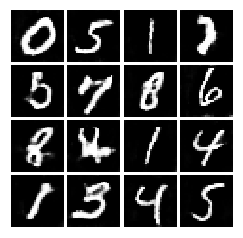


Iter: 1750, D: 1.09, G:1.154
Iter: 1800, D: 1.104, G:0.7116
Iter: 1850, D: 1.083, G:1.477
Iter: 1900, D: 1.134, G:0.8975
Iter: 1950, D: 1.095, G:1.155


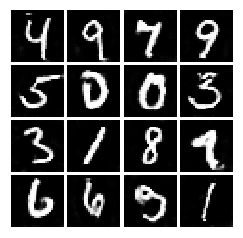


Iter: 2000, D: 1.118, G:0.9427
Iter: 2050, D: 1.057, G:0.9533
Iter: 2100, D: 1.083, G:0.8977
Iter: 2150, D: 1.408, G:0.4445
Iter: 2200, D: 1.084, G:0.9675


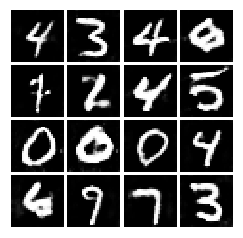


Iter: 2250, D: 0.9802, G:1.29
Iter: 2300, D: 1.142, G:1.075
Iter: 2350, D: 1.142, G:1.505
Iter: 2400, D: 1.036, G:1.082
Iter: 2450, D: 1.064, G:0.8462


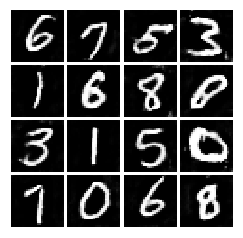


Iter: 2500, D: 1.058, G:1.76
Iter: 2550, D: 1.049, G:1.298
Iter: 2600, D: 1.202, G:0.8631
Iter: 2650, D: 1.357, G:0.6449
Iter: 2700, D: 1.039, G:0.9294


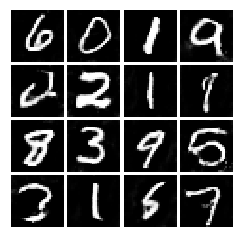


Iter: 2750, D: 0.925, G:1.582
Iter: 2800, D: 1.154, G:1.049
Iter: 2850, D: 1.051, G:0.725
Iter: 2900, D: 1.134, G:2.077
Iter: 2950, D: 1.215, G:2.294


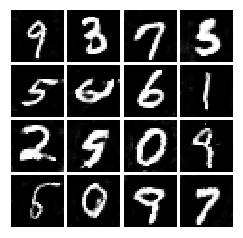


Iter: 3000, D: 0.9358, G:1.25
Iter: 3050, D: 1.269, G:0.5844
Iter: 3100, D: 0.9796, G:1.607
Iter: 3150, D: 0.9401, G:1.202
Iter: 3200, D: 1.536, G:0.8572


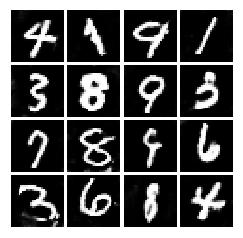


Iter: 3250, D: 0.9626, G:1.653
Iter: 3300, D: 1.184, G:2.216
Iter: 3350, D: 0.9147, G:1.661
Iter: 3400, D: 1.042, G:1.144
Iter: 3450, D: 1.405, G:1.611


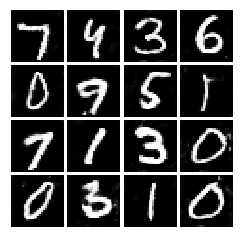


Iter: 3500, D: 0.9325, G:1.355
Iter: 3550, D: 1.073, G:2.251
Iter: 3600, D: 0.9169, G:1.85
Iter: 3650, D: 1.189, G:1.399
Iter: 3700, D: 0.9295, G:1.271


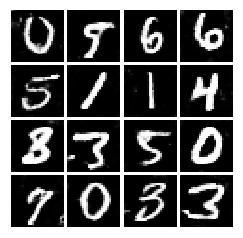


Iter: 3750, D: 0.9392, G:1.615
Iter: 3800, D: 1.667, G:1.857
Iter: 3850, D: 0.8036, G:1.0
Iter: 3900, D: 0.8447, G:1.333
Iter: 3950, D: 0.7955, G:1.202


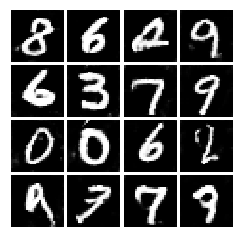


Iter: 4000, D: 0.8044, G:2.051
Iter: 4050, D: 0.8876, G:1.828
Iter: 4100, D: 0.8354, G:1.278
Iter: 4150, D: 1.334, G:0.9372
Iter: 4200, D: 0.8827, G:2.071


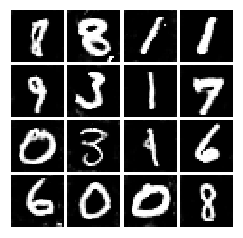


Iter: 4250, D: 0.9422, G:2.535
Iter: 4300, D: 1.055, G:1.128
Iter: 4350, D: 1.273, G:1.394
Iter: 4400, D: 0.8305, G:1.48
Iter: 4450, D: 0.8185, G:1.321


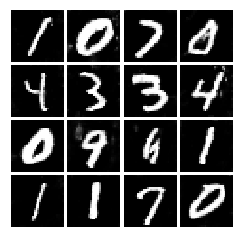


Iter: 4500, D: 0.8735, G:1.073
Iter: 4550, D: 0.8517, G:1.422
Iter: 4600, D: 0.9674, G:2.739
Iter: 4650, D: 0.7067, G:1.493
Iter: 4700, D: 0.8518, G:1.172


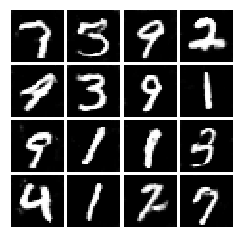


Iter: 4750, D: 0.7938, G:1.613
Iter: 4800, D: 0.903, G:1.544
Iter: 4850, D: 0.6961, G:2.212
Iter: 4900, D: 1.228, G:1.293
Iter: 4950, D: 0.7521, G:1.808


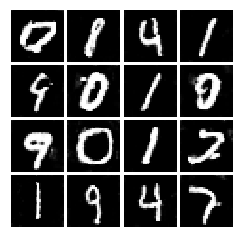


Iter: 5000, D: 0.7263, G:1.399
Iter: 5050, D: 0.6858, G:1.668
Iter: 5100, D: 0.6909, G:1.524
Iter: 5150, D: 0.9366, G:2.432
Iter: 5200, D: 0.8904, G:1.404


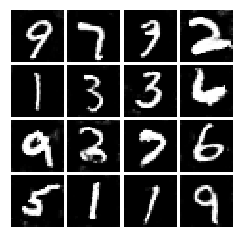


Iter: 5250, D: 0.9426, G:1.121
Iter: 5300, D: 0.6808, G:2.114
Iter: 5350, D: 0.8168, G:1.124
Iter: 5400, D: 2.108, G:2.205
Iter: 5450, D: 0.7342, G:1.984


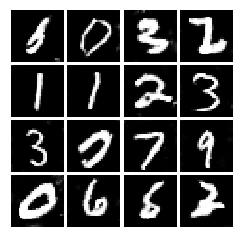


Iter: 5500, D: 0.672, G:1.789
Iter: 5550, D: 0.9005, G:1.209
Iter: 5600, D: 0.7116, G:2.276
Iter: 5650, D: 0.6241, G:1.69
Iter: 5700, D: 0.6784, G:1.642


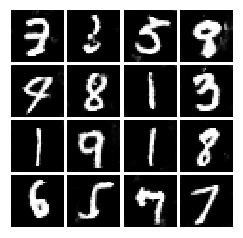


Iter: 5750, D: 0.6106, G:1.447
Iter: 5800, D: 0.6587, G:1.489
Iter: 5850, D: 0.9172, G:3.342
Iter: 5900, D: 0.8345, G:1.072
Iter: 5950, D: 0.687, G:1.44


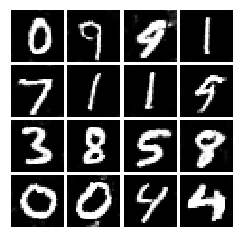


Iter: 6000, D: 0.7016, G:1.609
Iter: 6050, D: 1.1, G:1.342
Iter: 6100, D: 0.6574, G:1.458
Iter: 6150, D: 0.8988, G:1.409
Iter: 6200, D: 0.7208, G:1.76


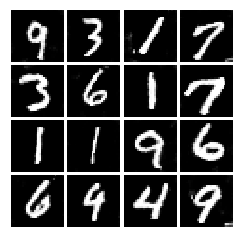


Iter: 6250, D: 0.6177, G:1.98
Iter: 6300, D: 0.6955, G:1.419
Iter: 6350, D: 0.6166, G:1.946
Iter: 6400, D: 0.7032, G:2.146
Iter: 6450, D: 0.5596, G:1.806


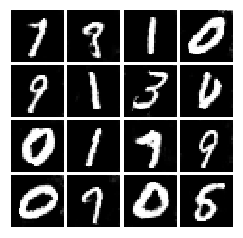


Iter: 6500, D: 0.577, G:2.0
Iter: 6550, D: 0.558, G:2.104
Iter: 6600, D: 1.158, G:3.4
Iter: 6650, D: 0.6058, G:2.118
Iter: 6700, D: 0.5521, G:1.98


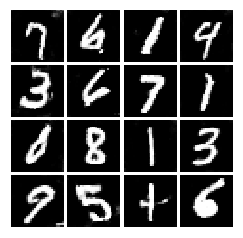


Iter: 6750, D: 0.7054, G:2.803
Iter: 6800, D: 0.7947, G:1.114
Iter: 6850, D: 0.6831, G:2.345
Iter: 6900, D: 0.7688, G:2.043
Iter: 6950, D: 0.7676, G:1.775


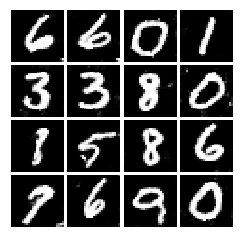


Iter: 7000, D: 0.6, G:1.89
Iter: 7050, D: 0.7352, G:1.512
Iter: 7100, D: 0.6555, G:2.724
Iter: 7150, D: 0.6795, G:2.133
Iter: 7200, D: 0.6421, G:1.907


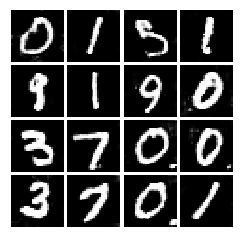


Iter: 7250, D: 0.6109, G:1.845
Iter: 7300, D: 0.6599, G:1.966
Iter: 7350, D: 0.5759, G:2.472
Iter: 7400, D: 0.5042, G:2.467
Iter: 7450, D: 0.6041, G:1.982


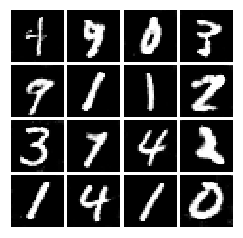


Iter: 7500, D: 0.5437, G:1.952
Iter: 7550, D: 0.6163, G:1.869
Iter: 7600, D: 0.6122, G:1.826
Iter: 7650, D: 0.5971, G:2.519
Iter: 7700, D: 0.5543, G:1.891


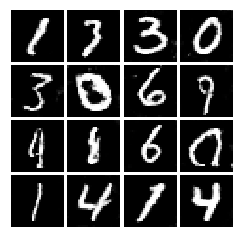


Iter: 7750, D: 0.7243, G:1.895
Iter: 7800, D: 0.7327, G:2.202
Iter: 7850, D: 1.471, G:1.358
Iter: 7900, D: 0.5638, G:2.097
Iter: 7950, D: 0.7286, G:1.812


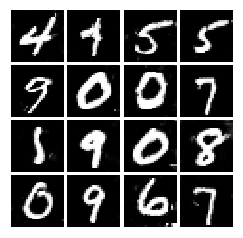


Iter: 8000, D: 0.5601, G:2.368
Iter: 8050, D: 0.6147, G:2.838
Iter: 8100, D: 0.6038, G:2.371
Iter: 8150, D: 0.5952, G:1.735
Iter: 8200, D: 0.5284, G:2.391


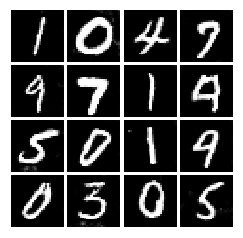


Iter: 8250, D: 0.5001, G:2.484
Iter: 8300, D: 0.7374, G:1.992
Iter: 8350, D: 0.5506, G:2.059
Iter: 8400, D: 0.6494, G:2.619
Iter: 8450, D: 0.6019, G:2.039


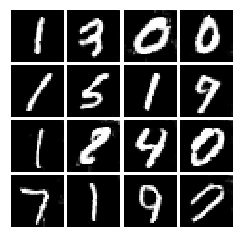


Iter: 8500, D: 0.5666, G:3.018
Iter: 8550, D: 0.6025, G:2.308
Model saved in file: /tmp/model.ckpt
Final images


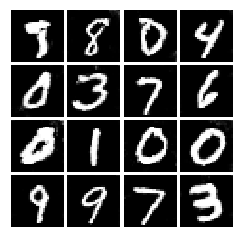

In [501]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    Dloss, Gloss = run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=20)

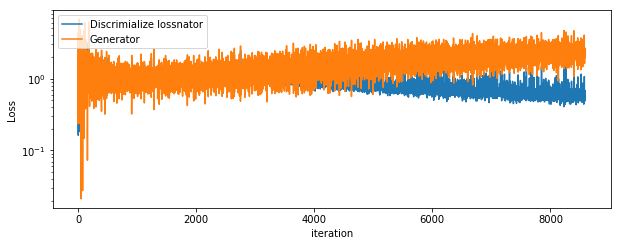

In [503]:
# Visualization
plt.subplot(2, 1, 2)
plt.plot(Dloss )
plt.plot(Gloss)
plt.legend(['Discrimialize lossnator', 'Generator'], loc='upper left')
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.show()

(96, 128, 96)
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


Original noise vector


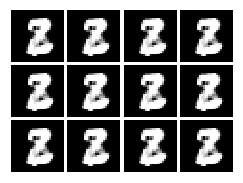

Modified noise vector, index = 0


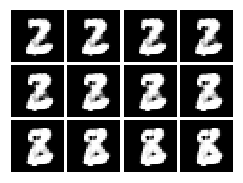

Modified noise vector, index = 1


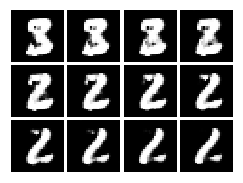

Modified noise vector, index = 2


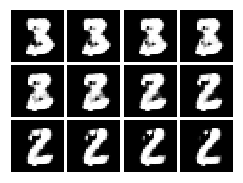

Modified noise vector, index = 3


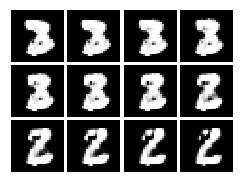

Modified noise vector, index = 4


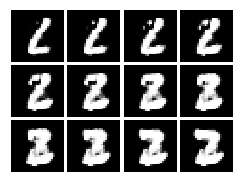

Modified noise vector, index = 5


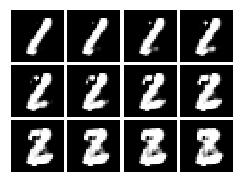

Modified noise vector, index = 6


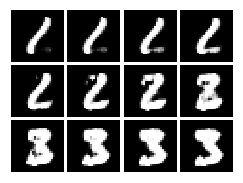

Modified noise vector, index = 7


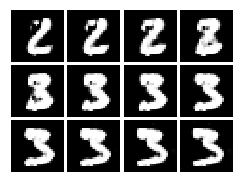

Modified noise vector, index = 8


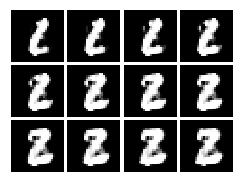

Modified noise vector, index = 9


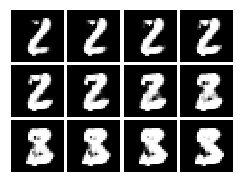

Modified noise vector, index = 10


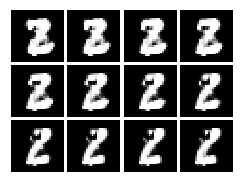

Modified noise vector, index = 11


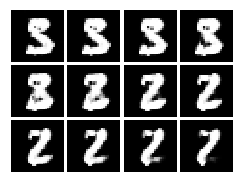

Modified noise vector, index = 12


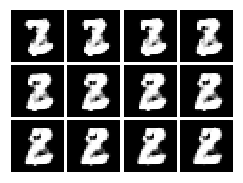

Modified noise vector, index = 13


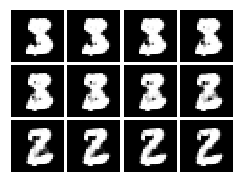

Modified noise vector, index = 14


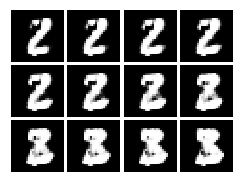

Modified noise vector, index = 15


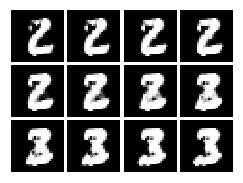

Modified noise vector, index = 16


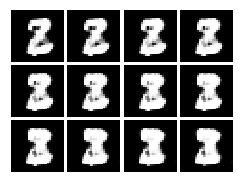

Modified noise vector, index = 17


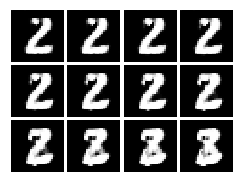

Modified noise vector, index = 18


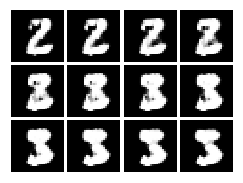

Modified noise vector, index = 19


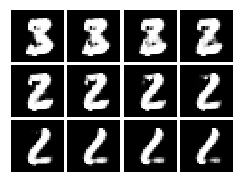

Modified noise vector, index = 20


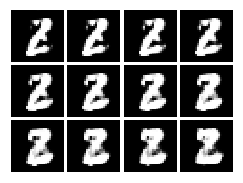

Modified noise vector, index = 21


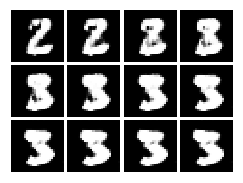

Modified noise vector, index = 22


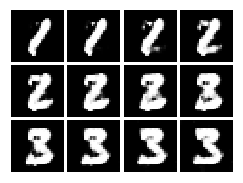

Modified noise vector, index = 23


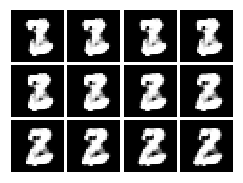

Modified noise vector, index = 24


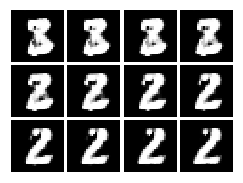

Modified noise vector, index = 25


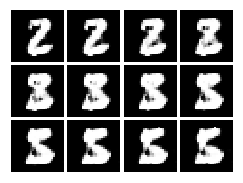

Modified noise vector, index = 26


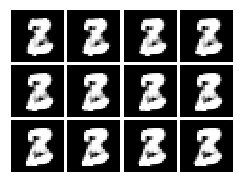

Modified noise vector, index = 27


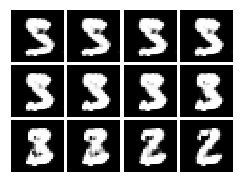

Modified noise vector, index = 28


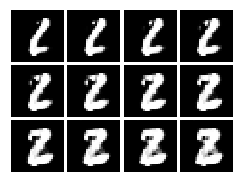

Modified noise vector, index = 29


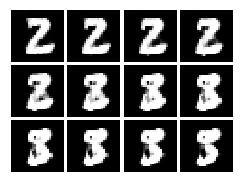

Modified noise vector, index = 30


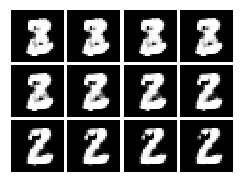

Modified noise vector, index = 31


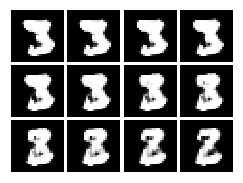

Modified noise vector, index = 32


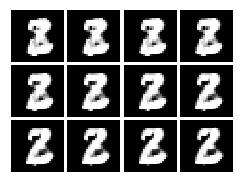

Modified noise vector, index = 33


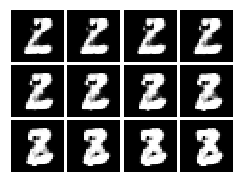

Modified noise vector, index = 34


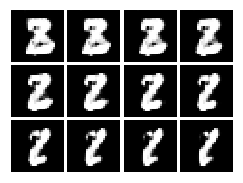

Modified noise vector, index = 35


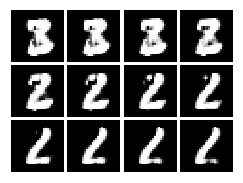

Modified noise vector, index = 36


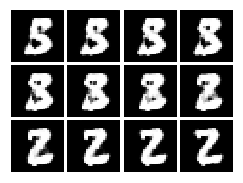

Modified noise vector, index = 37


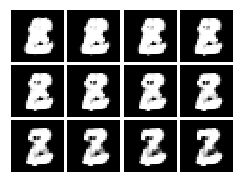

Modified noise vector, index = 38


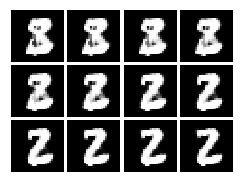

Modified noise vector, index = 39


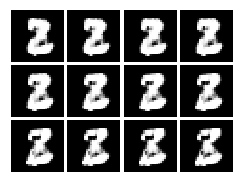

Modified noise vector, index = 40


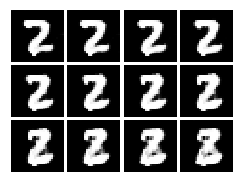

Modified noise vector, index = 41


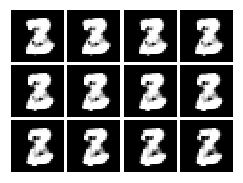

Modified noise vector, index = 42


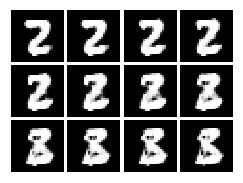

Modified noise vector, index = 43


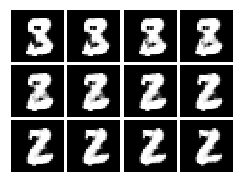

Modified noise vector, index = 44


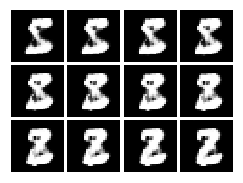

Modified noise vector, index = 45


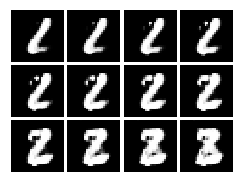

Modified noise vector, index = 46


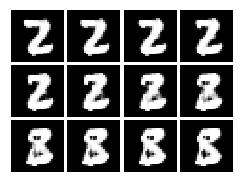

Modified noise vector, index = 47


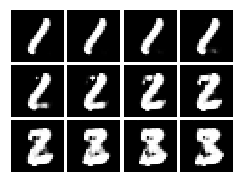

Modified noise vector, index = 48


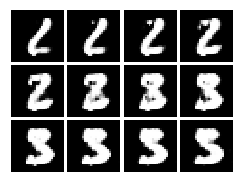

Modified noise vector, index = 49


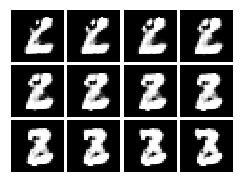

Modified noise vector, index = 50


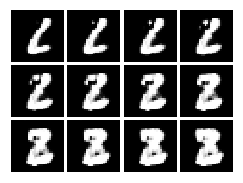

Modified noise vector, index = 51


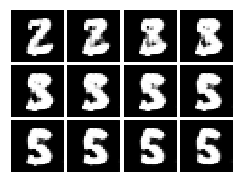

Modified noise vector, index = 52


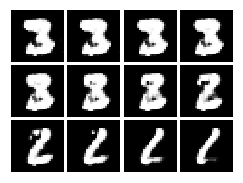

Modified noise vector, index = 53


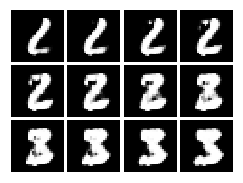

Modified noise vector, index = 54


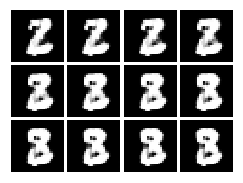

Modified noise vector, index = 55


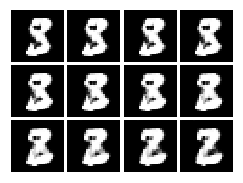

Modified noise vector, index = 56


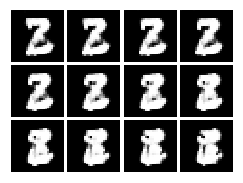

Modified noise vector, index = 57


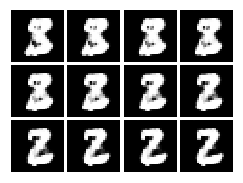

Modified noise vector, index = 58


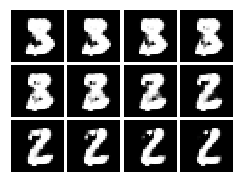

Modified noise vector, index = 59


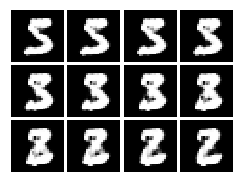

Modified noise vector, index = 60


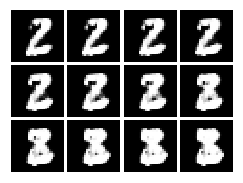

Modified noise vector, index = 61


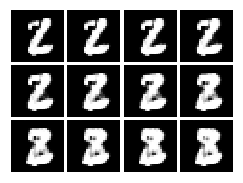

Modified noise vector, index = 62


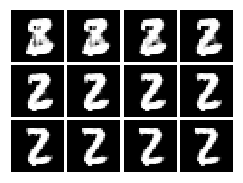

Modified noise vector, index = 63


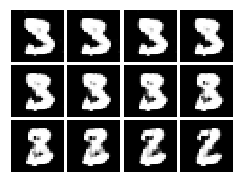

Modified noise vector, index = 64


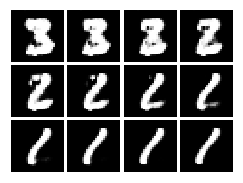

Modified noise vector, index = 65


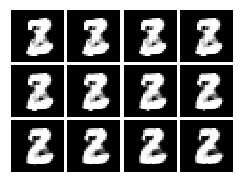

Modified noise vector, index = 66


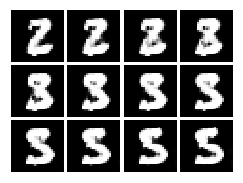

Modified noise vector, index = 67


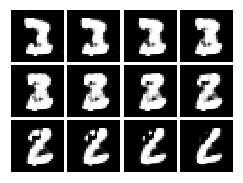

Modified noise vector, index = 68


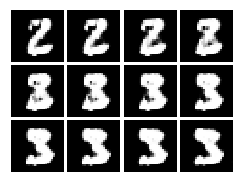

Modified noise vector, index = 69


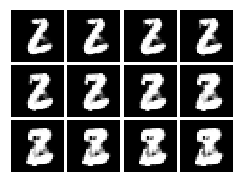

Modified noise vector, index = 70


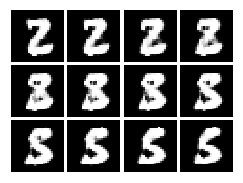

Modified noise vector, index = 71


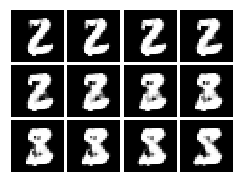

Modified noise vector, index = 72


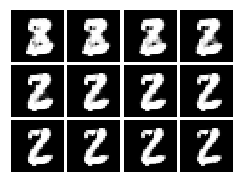

Modified noise vector, index = 73


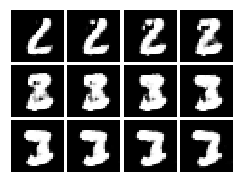

Modified noise vector, index = 74


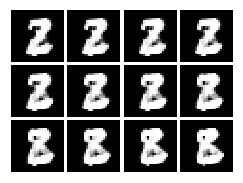

Modified noise vector, index = 75


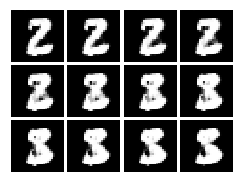

Modified noise vector, index = 76


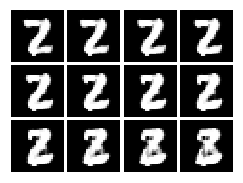

Modified noise vector, index = 77


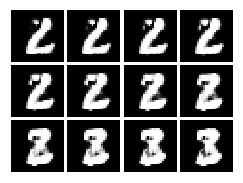

Modified noise vector, index = 78


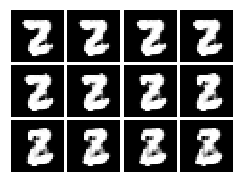

Modified noise vector, index = 79


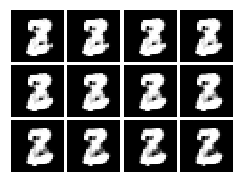

Modified noise vector, index = 80


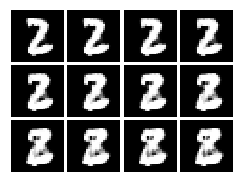

Modified noise vector, index = 81


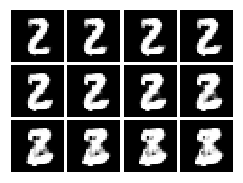

Modified noise vector, index = 82


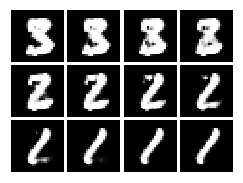

Modified noise vector, index = 83


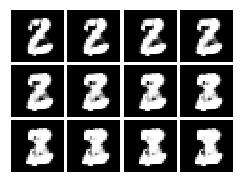

Modified noise vector, index = 84


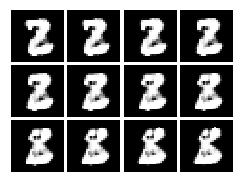

Modified noise vector, index = 85


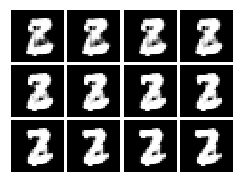

Modified noise vector, index = 86


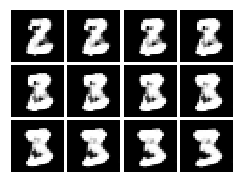

Modified noise vector, index = 87


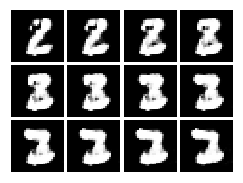

Modified noise vector, index = 88


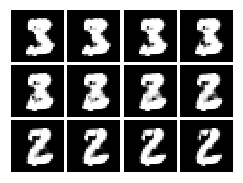

Modified noise vector, index = 89


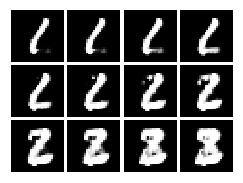

Modified noise vector, index = 90


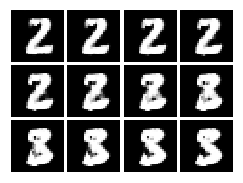

Modified noise vector, index = 91


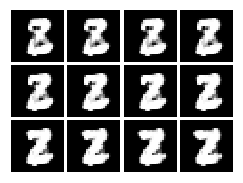

Modified noise vector, index = 92


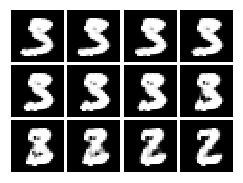

Modified noise vector, index = 93


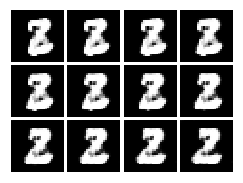

Modified noise vector, index = 94


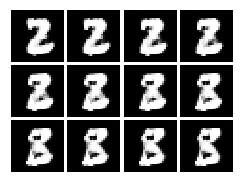

Modified noise vector, index = 95


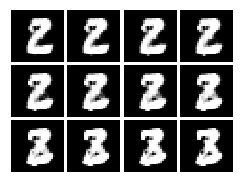

In [504]:
sample_size = 12
tf.reset_default_graph()
z = sample_noise(batch_size, noise_dim)

npvm = np.zeros((noise_dim,batch_size, noise_dim))
samples = np.zeros((noise_dim,batch_size, 784))
npv = np.random.uniform(-1,1,(batch_size, noise_dim))
sr = np.random.uniform(-1,1,( noise_dim))
  
for j in range (sample_size):
    npv[j,:] = sr
 
for k in range (noise_dim):
    npvm[k] = np.copy(npv)
    for i in range(sample_size):
        npvm[k,i,k] = (2.0 / sample_size)*i - 1
print (npvm.shape)
        
kz = tf.Variable(tf.zeros((batch_size, noise_dim), tf.float32))
# generated images
G_sample = generator(kz )
with get_session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "/tmp/model.ckpt")
    kz.load(npv, session=sess)
    samples_a = sess.run(G_sample )
    for k in range(noise_dim):
        npvm_x = np.copy(npvm[k])
        kz.load(npvm_x, session=sess)
        samples_x = sess.run(G_sample)
        samples[k,:,:] = np.copy(samples_x)
print ('Original noise vector')
fig = show_images(samples_a[:sample_size])
plt.show()

for k in range(noise_dim):
    print ('Modified noise vector, index = %d'% k)
    fig = show_images(samples[k][:sample_size])
    plt.show()
 


# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did here

# WGAN-GP (Small Extra Credit)

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [347]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
        input_layer = tf.reshape(x,[-1,28,28,1])
        conv1 = tf.layers.conv2d(input_layer,filters=64,kernel_size=[4,4],strides=2,padding="valid")
        conv1l = leaky_relu(conv1,alpha=0.01) 
        conv2 = tf.layers.conv2d(conv1l,filters=128,kernel_size=[4,4],strides=2,padding="valid")
        conv2l = leaky_relu(conv2,alpha= 0.01)
        #BatchNorm
        bn1 = tf.layers.batch_normalization(conv2l,axis=-1,training=True)
        #Flatten
        fl1 = tf.reshape(bn1,[-1,3200])
        #Fully connected 1024, LeakyReLU
        fc1 = tf.layers.dense(inputs=fl1,units=1024,use_bias=True)
        fc1l = leaky_relu(fc1,alpha=0.01)      
        #Fully connected size 1
        logits = tf.layers.dense(inputs=fc1l,units=1,use_bias=True)
        return logits
test_discriminator(3411649)

Correct number of parameters in discriminator.


In [457]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [454]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    
    
    # TODO: compute D_loss and G_loss
    
    D_loss = None
    G_loss = None
    
    # want to minimize D_loss:   
    #   Minimize logits_fake: the probablility that image is real for *fake images*
    #   Maximize logits_real: the probability that image is real for real images
    D_loss  =   tf.reduce_mean(logits_fake) - tf.reduce_mean(logits_real)  
  
    
    # want to minimize G_loss:
    #   Maximize logits_fake: the probability that image is real for fake images
    G_loss =    -1 * tf.reduce_mean(logits_fake)
   
    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform([batch_size,1])
    x_hat =  x * eps +  G_sample * (1-eps)

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator(x_hat), x_hat)[0] 
        # grad_D_x_hat[0] is the first element of len-1 list that holds the derivative tensor
        # tensor shape is [Batch_size, 784]
    
    grad_norm = tf.norm(grad_D_x_hat , axis=1, ord=2)  # ord=2 means Euclidian
  
    grad_pen = tf.reduce_mean(tf.square(grad_norm-1))
    
    D_loss += lam*grad_pen
      
    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

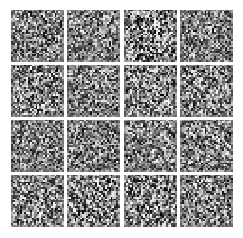


Iter: 0, D: 16.56, G:0.5351
Iter: 50, D: -1.051, G:-4.508
Iter: 100, D: -1.002, G:-2.431
Iter: 150, D: -0.3578, G:0.02654
Iter: 200, D: -0.7866, G:0.1328


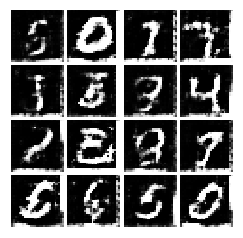


Iter: 250, D: -0.6652, G:-1.945
Iter: 300, D: -0.4981, G:-0.8619
Iter: 350, D: -0.253, G:1.349
Iter: 400, D: -0.06483, G:-3.958
Iter: 450, D: -0.6575, G:-1.322


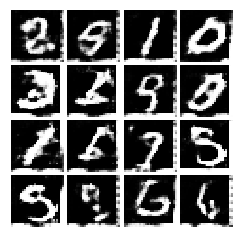


Iter: 500, D: 0.07, G:-2.804
Iter: 550, D: -0.5052, G:-4.462
Iter: 600, D: -0.4861, G:0.2589
Iter: 650, D: -0.6433, G:-1.794
Iter: 700, D: -0.7216, G:-2.935


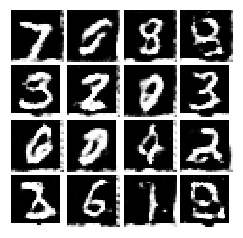


Iter: 750, D: -1.349, G:-3.123
Iter: 800, D: -0.8176, G:-4.503
Iter: 850, D: -1.355, G:-0.782
Iter: 900, D: -0.4443, G:-6.825
Iter: 950, D: -0.3749, G:0.03656


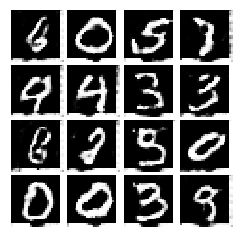


Iter: 1000, D: -0.9348, G:-1.963
Iter: 1050, D: -0.02997, G:-5.814
Iter: 1100, D: -0.3871, G:-5.604
Iter: 1150, D: -0.7194, G:-0.3962
Iter: 1200, D: 0.3711, G:1.373


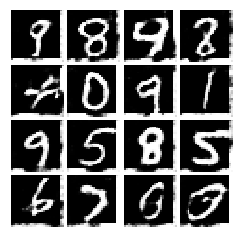


Iter: 1250, D: -0.1685, G:-4.313
Iter: 1300, D: -0.2934, G:4.233
Iter: 1350, D: -0.7504, G:-1.314
Iter: 1400, D: -0.4088, G:-0.509
Iter: 1450, D: -0.9074, G:-7.703


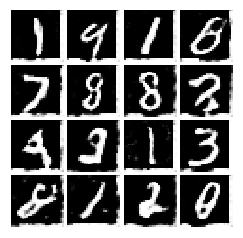


Iter: 1500, D: -0.5924, G:-3.194
Iter: 1550, D: -1.203, G:-0.5148
Iter: 1600, D: 0.073, G:-4.913
Iter: 1650, D: 0.0149, G:-3.065
Iter: 1700, D: -0.3763, G:-6.186


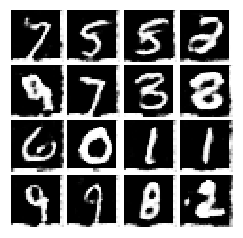


Iter: 1750, D: -0.5106, G:-3.961
Iter: 1800, D: -0.7314, G:-2.375
Iter: 1850, D: -0.5772, G:-4.877
Iter: 1900, D: -0.5552, G:-0.7571
Iter: 1950, D: -0.04654, G:1.547


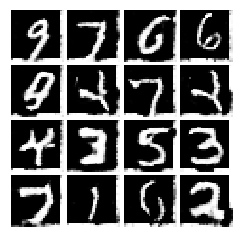


Iter: 2000, D: 0.3093, G:-0.1399
Iter: 2050, D: -0.06811, G:0.103
Iter: 2100, D: -0.4413, G:2.523
Model saved in file: /tmp/model.ckpt
Final images


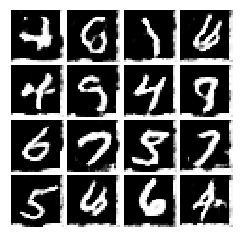

In [455]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    Dloss, Gloss = run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=5)

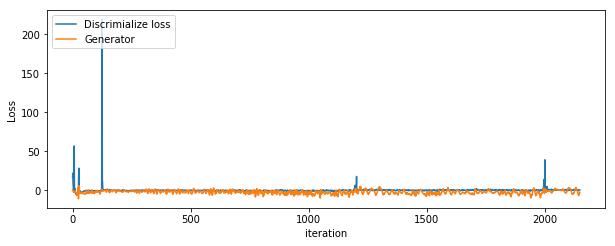

In [456]:
# Visualization
plt.subplot(2, 1, 2)
plt.plot(Dloss )
plt.plot( Gloss)
plt.legend(['Discrimialize loss', 'Generator'], loc='upper left')
#plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.show()

In [ ]:
# ************ InfoGAN **********************
# Using DC-GAN structure


In [631]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    
    # Using sigmoid as a trick to compute log prob for "true" class, assuming the 
    #score for the "other" class is 0 (hence: exp(0) = 1, the "1" is provided by the 
    # sigmoid denominator)
    
    label0 = tf.zeros_like(logits_fake)
    label1 = tf.ones_like(logits_real)
    ones = tf.ones_like(logits_real)
    
    #  sigmoid_cross_entropy_with_logits with label=1: computes -log(sigmoid(x)), for fake x
    lg_a = tf.nn.sigmoid_cross_entropy_with_logits(labels=label1,logits=logits_fake) 
    # want to minimize the delta between fake "positives" and 1  (== good generator)
    
    #  sigmoid_cross_entropy_with_logits with label=1: computes -log(sigmoid(x)), for real x
    ld_a = (tf.nn.sigmoid_cross_entropy_with_logits(labels=label1,logits=logits_real))
    # want to minimize the delat between real "positives" and 1 (== good Discriminator)
 
    #  sigmoid_cross_entropy_with_logits with label=0: computes -log(1- sigmoid(x)), for fake x
    ld_b = (tf.nn.sigmoid_cross_entropy_with_logits(labels=label0,logits=logits_fake) )
    # want to minimize the delat between fake "positives" and 0 (== good Discriminator)

    
    
    D_loss= tf.reduce_mean(ld_a + ld_b)
    G_loss =   tf.reduce_mean(lg_a)

    
    return D_loss, G_loss, ld_a, ld_b

In [529]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        # inpu reshape layer
        input_layer = tf.reshape(x,[-1,28,28,1])
        conv1 = tf.layers.conv2d(input_layer,filters=32,kernel_size=[5,5],padding="valid")
        conv1l = leaky_relu(conv1,alpha=0.01)
        pool1 = tf.layers.max_pooling2d(conv1l,pool_size=[2,2],strides=2)
        conv2 = tf.layers.conv2d(pool1,filters=64,kernel_size=[5,5],padding="valid")
        conv2l = leaky_relu(conv2,alpha= 0.01)
        pool2 = tf.layers.max_pooling2d(conv2l,pool_size=[2,2],strides=2) 
        pool2_f =tf.reshape(pool2,[-1,4*4*64])    #3136
        fc1 = tf.layers.dense(inputs=pool2_f,units=4*4*64,use_bias=True)
        fc1l = leaky_relu(fc1,alpha=0.01)
        logits = tf.layers.dense(inputs=fc1l,units=1,use_bias=True)
        #Add the discrete logits
        cl_logits = tf.layers.dense(inputs=fc1l,units=10,use_bias=True)
        logits_d = tf.nn.softmax(cl_logits)
        return [logits, logits_d]

In [530]:
def generator(z, is_training=True):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        fc1 = tf.layers.dense(inputs=z,units=1024,activation=tf.nn.relu,use_bias=True)
        fc1b = tf.layers.batch_normalization(fc1,axis=-1,training=is_training)
        fc2 = tf.layers.dense(inputs=fc1b,units=7*7*128,activation=tf.nn.relu,use_bias=True)
        fc2b = tf.layers.batch_normalization(fc2,axis=-1,training=is_training)
        fc2c = tf.reshape(fc2b,[-1,7,7,128])
        dc1 = tf.layers.conv2d_transpose(fc2c,filters=64,kernel_size=[4,4],strides=(2,2),\
                                         activation=tf.nn.relu ,padding='same')
        dc1b = tf.layers.batch_normalization(dc1,axis=-1,training=is_training)
        
        dc2 =  tf.layers.conv2d_transpose(dc1b,filters=1,kernel_size=[4,4],strides=(2,2),\
                                         activation=tf.nn.tanh,padding='same')         
        img = tf.reshape(dc2,[-1,784])
        return img

In [741]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96
latent_discrete_dim = 10
latent_cont_dim = 2
lamda = 0.5

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)

# Noise vector is made out of z_disc[1], z_cont[], z_rand[]
z_disc = sample_noise(batch_size, latent_discrete_dim)
z_cont = sample_noise(batch_size, latent_cont_dim)
z_bal =  sample_noise(batch_size, noise_dim - latent_cont_dim - latent_discrete_dim)
z = tf.concat([z_disc, z_cont, z_bal],1)
 
# generated images
G_sample = generator(z)
kz = tf.Variable(tf.zeros((batch_size, noise_dim), tf.float32))

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    [logits_real,logits_d] = discriminator(preprocess_img(x)) 
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)[0]
    # cross entropy term
    z_disc_s = tf.nn.softmax(z_disc)
    
    # de value is large if labels distribution significantly differs from disc noise vector
    de= tf.nn.sigmoid_cross_entropy_with_logits(labels=z_disc_s,logits=logits_d)
    d_ent = tf.reduce_mean(de)
    
# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss, D_loss_a, D_loss_b = gan_loss(logits_real, logits_fake)
# calculate the extra cross-entropy-based terms for latent variables
# we want to minimize the cross-entropy term, to make labels  correlate with latent noise elements 
D_loss += lamda * d_ent
G_loss += lamda * d_ent

D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
#D_train_step_a = D_solver.minimize(D_loss_a, var_list=D_vars)
#D_train_step_b = D_solver.minimize(D_loss_b, var_list=D_vars)

G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

In [742]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128 , num_epoch=5):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    noise_adder_factor = 0.1
    D_loss_history = []
    G_loss_history = []
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        noise_adder_factor *= 0.99
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        iz = np.random.uniform(size =(minibatch.shape[0], minibatch.shape[1]))   #just some noise
        minibatch_c = np.copy(minibatch) * (1-noise_adder_factor)
        minibatch_c  += noise_adder_factor * iz
         
        _, D_loss_curr = sess.run([D_train_step , D_loss ], feed_dict={x: minibatch_c})
      
        _, G_loss_curr = sess.run([G_train_step, G_loss],feed_dict={x: minibatch})
      
        #log the loss history
        D_loss_history.append(D_loss_curr)
        G_loss_history.append(G_loss_curr)
        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    saver = tf.train.Saver()
    save_path = saver.save(sess, "/tmp/model.ckpt")
    print("Model saved in file: %s" % save_path)
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()
    return (D_loss_history, G_loss_history)

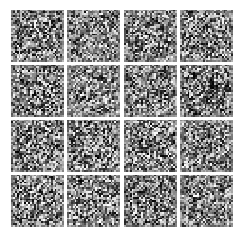


Iter: 0, D: 1.773, G:1.29
Iter: 50, D: 0.8827, G:1.466
Iter: 100, D: 1.236, G:1.54
Iter: 150, D: 1.381, G:2.311
Iter: 200, D: 1.528, G:1.327


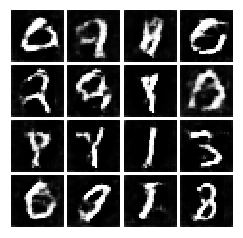


Iter: 250, D: 1.451, G:1.287
Iter: 300, D: 1.435, G:1.614
Iter: 350, D: 1.501, G:1.242
Iter: 400, D: 1.452, G:1.337
Iter: 450, D: 1.587, G:1.002


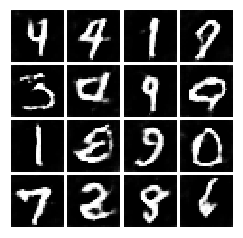


Iter: 500, D: 1.52, G:1.217
Iter: 550, D: 1.493, G:1.404
Iter: 600, D: 1.499, G:1.283
Iter: 650, D: 1.567, G:1.172
Iter: 700, D: 1.582, G:1.577


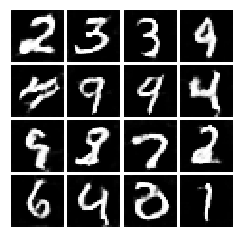


Iter: 750, D: 1.484, G:1.596
Iter: 800, D: 1.485, G:1.363
Iter: 850, D: 1.608, G:1.255
Iter: 900, D: 1.529, G:1.342
Iter: 950, D: 1.515, G:1.312


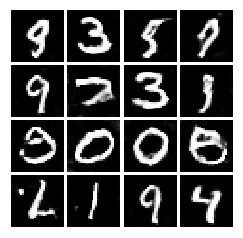


Iter: 1000, D: 1.482, G:1.767
Iter: 1050, D: 1.54, G:1.73
Iter: 1100, D: 1.51, G:1.557
Iter: 1150, D: 1.539, G:1.604
Iter: 1200, D: 1.571, G:1.387


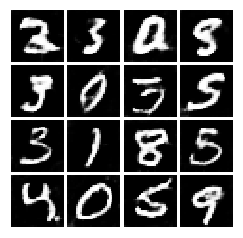


Iter: 1250, D: 1.498, G:2.034
Iter: 1300, D: 1.499, G:1.665
Iter: 1350, D: 1.473, G:1.33
Iter: 1400, D: 1.413, G:1.357
Iter: 1450, D: 1.518, G:1.279


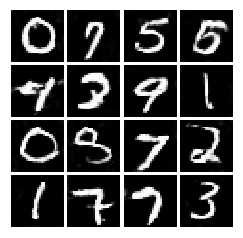


Iter: 1500, D: 1.532, G:1.374
Iter: 1550, D: 1.514, G:1.341
Iter: 1600, D: 1.426, G:1.327
Iter: 1650, D: 1.45, G:1.705
Iter: 1700, D: 1.525, G:1.428


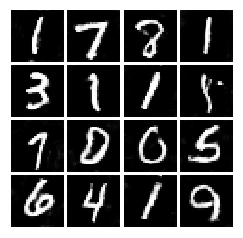


Iter: 1750, D: 1.493, G:1.389
Iter: 1800, D: 1.487, G:1.426
Iter: 1850, D: 1.471, G:0.9393
Iter: 1900, D: 1.672, G:2.418
Iter: 1950, D: 1.6, G:0.7969


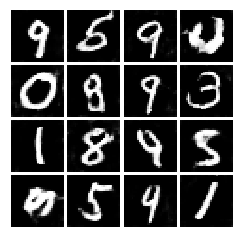


Iter: 2000, D: 1.47, G:1.396
Iter: 2050, D: 1.458, G:1.274
Iter: 2100, D: 1.442, G:1.459
Iter: 2150, D: 1.485, G:0.8042
Iter: 2200, D: 1.397, G:1.296


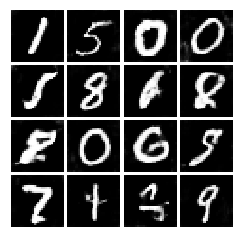


Iter: 2250, D: 1.482, G:1.46
Iter: 2300, D: 1.391, G:1.277
Iter: 2350, D: 1.484, G:1.263
Iter: 2400, D: 1.365, G:1.364
Iter: 2450, D: 1.482, G:1.258


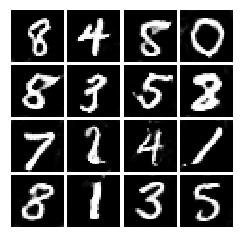


Iter: 2500, D: 1.406, G:1.744
Iter: 2550, D: 1.514, G:1.698
Iter: 2600, D: 1.361, G:1.203
Iter: 2650, D: 1.436, G:1.521
Iter: 2700, D: 1.348, G:1.544


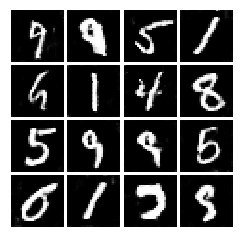


Iter: 2750, D: 1.342, G:1.35
Iter: 2800, D: 1.296, G:1.577
Iter: 2850, D: 1.318, G:1.725
Iter: 2900, D: 1.391, G:1.37
Iter: 2950, D: 1.309, G:1.704


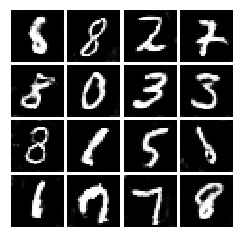


Iter: 3000, D: 1.253, G:1.888
Iter: 3050, D: 1.354, G:1.721
Iter: 3100, D: 1.268, G:1.432
Iter: 3150, D: 1.201, G:1.681
Iter: 3200, D: 1.434, G:1.199


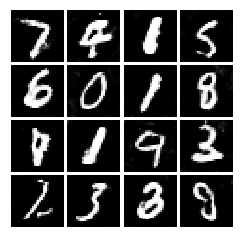


Iter: 3250, D: 1.252, G:1.731
Iter: 3300, D: 1.219, G:1.459
Iter: 3350, D: 1.258, G:1.801
Iter: 3400, D: 1.23, G:1.715
Iter: 3450, D: 1.286, G:1.537


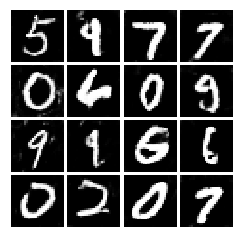


Iter: 3500, D: 1.329, G:2.635
Iter: 3550, D: 1.238, G:1.039
Iter: 3600, D: 1.178, G:1.874
Iter: 3650, D: 1.262, G:1.769
Iter: 3700, D: 1.219, G:1.362


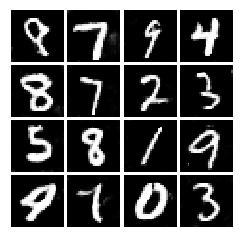


Iter: 3750, D: 1.377, G:2.08
Iter: 3800, D: 1.197, G:1.665
Iter: 3850, D: 1.063, G:1.751
Iter: 3900, D: 1.168, G:2.416
Iter: 3950, D: 1.281, G:1.666


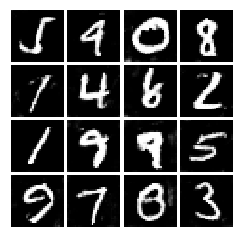


Iter: 4000, D: 1.173, G:2.414
Iter: 4050, D: 1.103, G:1.791
Iter: 4100, D: 1.239, G:2.243
Iter: 4150, D: 1.313, G:1.663
Iter: 4200, D: 1.13, G:1.824


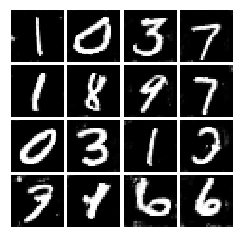


Iter: 4250, D: 1.215, G:2.059
Iter: 4300, D: 1.198, G:2.074
Iter: 4350, D: 1.159, G:1.869
Iter: 4400, D: 1.268, G:1.899
Iter: 4450, D: 1.743, G:1.307


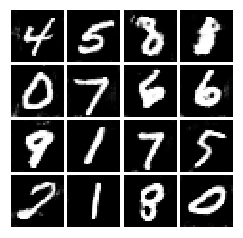


Iter: 4500, D: 1.183, G:1.379
Iter: 4550, D: 1.215, G:1.947
Iter: 4600, D: 1.098, G:1.854
Iter: 4650, D: 1.097, G:1.892
Iter: 4700, D: 1.258, G:1.641


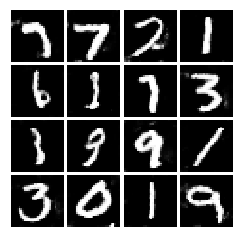


Iter: 4750, D: 1.146, G:2.139
Iter: 4800, D: 1.148, G:2.254
Iter: 4850, D: 1.061, G:2.629
Iter: 4900, D: 1.06, G:1.984
Iter: 4950, D: 1.355, G:1.582


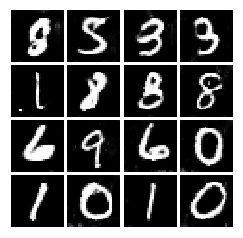


Iter: 5000, D: 1.076, G:1.932
Iter: 5050, D: 1.04, G:2.881
Iter: 5100, D: 1.115, G:2.416
Iter: 5150, D: 1.004, G:1.802
Iter: 5200, D: 1.08, G:2.001


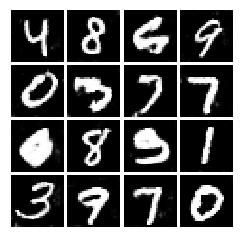


Iter: 5250, D: 1.106, G:1.522
Iter: 5300, D: 1.023, G:2.281
Iter: 5350, D: 1.088, G:2.497
Iter: 5400, D: 1.122, G:1.574
Iter: 5450, D: 1.322, G:2.595


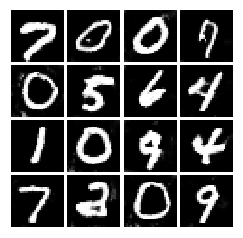


Iter: 5500, D: 1.076, G:2.272
Iter: 5550, D: 1.111, G:2.356
Iter: 5600, D: 1.081, G:1.838
Iter: 5650, D: 1.091, G:1.822
Iter: 5700, D: 1.014, G:2.436


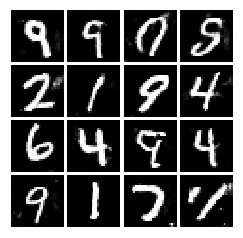


Iter: 5750, D: 1.185, G:1.61
Iter: 5800, D: 1.042, G:2.434
Iter: 5850, D: 0.9313, G:2.281
Iter: 5900, D: 0.9634, G:2.763
Iter: 5950, D: 0.9787, G:3.138


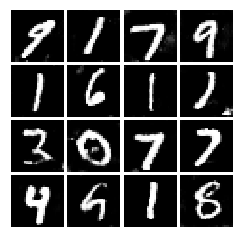


Iter: 6000, D: 1.041, G:2.295
Iter: 6050, D: 0.9839, G:2.68
Iter: 6100, D: 0.8988, G:2.426
Iter: 6150, D: 1.135, G:1.983
Iter: 6200, D: 0.9478, G:2.125


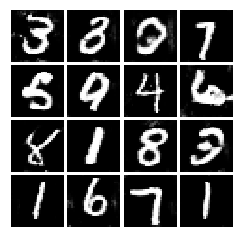


Iter: 6250, D: 1.018, G:3.116
Iter: 6300, D: 1.058, G:3.073
Iter: 6350, D: 0.9939, G:3.731
Iter: 6400, D: 1.057, G:2.253
Iter: 6450, D: 1.535, G:1.507


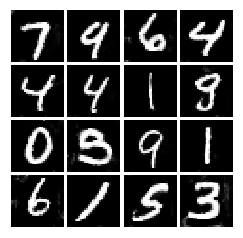


Iter: 6500, D: 1.107, G:2.346
Iter: 6550, D: 0.9202, G:2.621
Iter: 6600, D: 0.9129, G:2.114
Iter: 6650, D: 0.9363, G:1.645
Iter: 6700, D: 0.9188, G:2.596


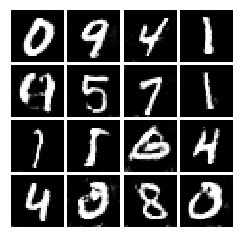


Iter: 6750, D: 1.251, G:2.051
Iter: 6800, D: 0.9141, G:2.772
Iter: 6850, D: 0.9998, G:2.104
Iter: 6900, D: 0.9292, G:2.632
Iter: 6950, D: 0.9485, G:2.77


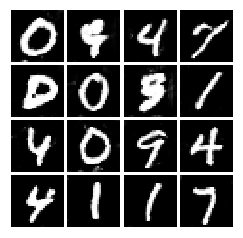


Iter: 7000, D: 1.232, G:2.242
Iter: 7050, D: 1.138, G:1.968
Iter: 7100, D: 1.018, G:2.158
Iter: 7150, D: 1.004, G:2.634
Iter: 7200, D: 1.069, G:2.753


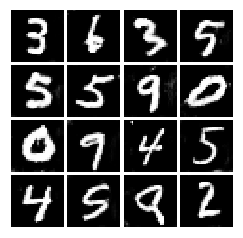


Iter: 7250, D: 1.045, G:1.728
Iter: 7300, D: 0.8316, G:2.68
Iter: 7350, D: 1.251, G:1.731
Iter: 7400, D: 1.064, G:2.169
Iter: 7450, D: 1.166, G:1.993


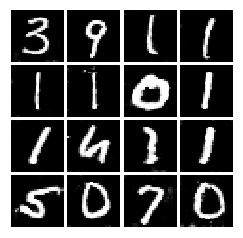


Iter: 7500, D: 0.9416, G:2.917
Iter: 7550, D: 0.9912, G:2.951
Iter: 7600, D: 0.964, G:2.594
Iter: 7650, D: 0.9317, G:2.186
Iter: 7700, D: 0.9795, G:2.541


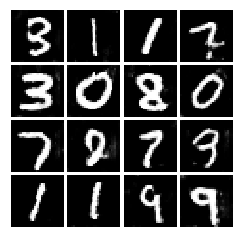


Iter: 7750, D: 1.049, G:3.513
Iter: 7800, D: 1.042, G:2.978
Iter: 7850, D: 1.005, G:2.527
Iter: 7900, D: 0.8924, G:2.163
Iter: 7950, D: 0.9781, G:2.59


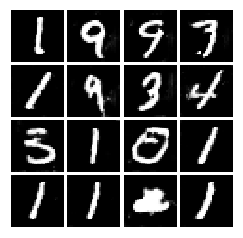


Iter: 8000, D: 0.9009, G:2.607
Iter: 8050, D: 0.9338, G:2.761
Iter: 8100, D: 0.8334, G:2.356
Iter: 8150, D: 0.8343, G:2.809
Iter: 8200, D: 0.92, G:2.995


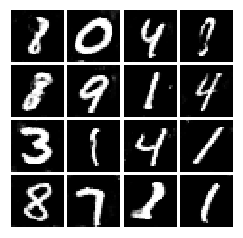


Iter: 8250, D: 0.8449, G:2.908
Iter: 8300, D: 0.9095, G:2.721
Iter: 8350, D: 0.9603, G:2.0
Iter: 8400, D: 0.9408, G:3.643
Iter: 8450, D: 0.9065, G:2.577


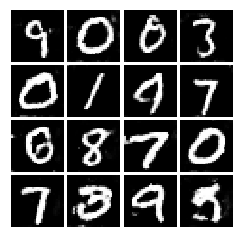


Iter: 8500, D: 0.8953, G:2.89
Iter: 8550, D: 0.8769, G:2.18
Iter: 8600, D: 0.911, G:2.371
Iter: 8650, D: 0.9389, G:2.652
Iter: 8700, D: 1.624, G:4.697


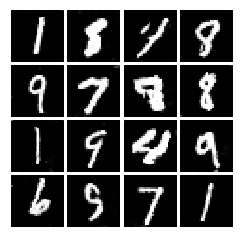


Iter: 8750, D: 0.9099, G:2.041
Iter: 8800, D: 0.9093, G:2.902
Iter: 8850, D: 0.8612, G:2.735
Iter: 8900, D: 0.9166, G:2.299
Iter: 8950, D: 0.7841, G:2.652


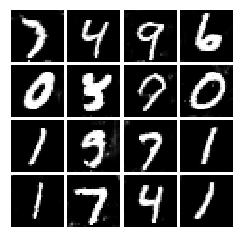


Iter: 9000, D: 0.8686, G:2.882
Iter: 9050, D: 0.8967, G:2.753
Iter: 9100, D: 0.9613, G:3.722
Iter: 9150, D: 0.8107, G:3.005
Iter: 9200, D: 1.007, G:4.699


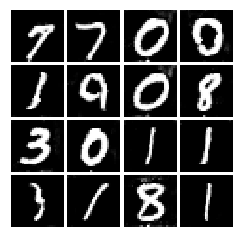


Iter: 9250, D: 0.8098, G:2.952
Iter: 9300, D: 0.7947, G:2.738
Iter: 9350, D: 0.9049, G:2.979
Iter: 9400, D: 0.9758, G:4.072
Iter: 9450, D: 0.9638, G:2.64


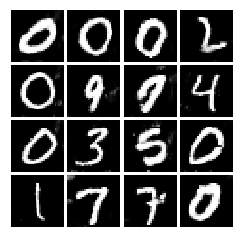


Iter: 9500, D: 0.741, G:3.394
Iter: 9550, D: 0.7654, G:2.763
Iter: 9600, D: 0.8952, G:2.043
Iter: 9650, D: 0.7964, G:3.067
Iter: 9700, D: 0.8473, G:3.256


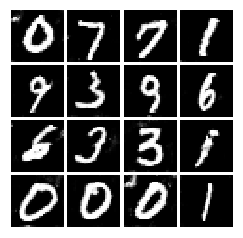


Iter: 9750, D: 0.813, G:3.321
Iter: 9800, D: 1.144, G:4.005
Iter: 9850, D: 0.8712, G:3.058
Iter: 9900, D: 0.8677, G:2.864
Iter: 9950, D: 0.9108, G:2.117


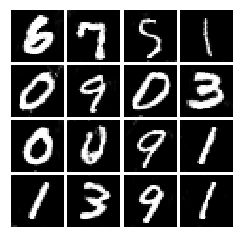


Iter: 10000, D: 0.9193, G:2.447
Iter: 10050, D: 0.7511, G:3.089
Iter: 10100, D: 0.7998, G:3.225
Iter: 10150, D: 0.75, G:3.465
Iter: 10200, D: 0.7748, G:3.184


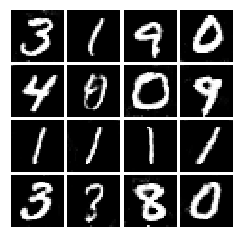


Iter: 10250, D: 0.8765, G:3.244
Iter: 10300, D: 0.8803, G:4.296
Iter: 10350, D: 0.8383, G:3.161
Iter: 10400, D: 1.003, G:2.462
Iter: 10450, D: 0.7358, G:3.755


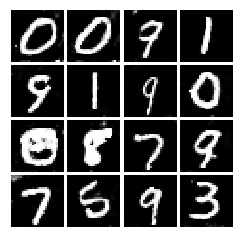


Iter: 10500, D: 0.8012, G:3.693
Iter: 10550, D: 0.7347, G:4.429
Iter: 10600, D: 0.9793, G:3.94
Iter: 10650, D: 0.8399, G:2.469
Iter: 10700, D: 0.9271, G:3.998


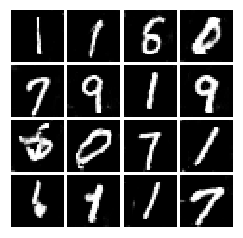


Iter: 10750, D: 0.8614, G:4.017
Iter: 10800, D: 0.9588, G:4.673
Iter: 10850, D: 0.7612, G:3.504
Iter: 10900, D: 0.6939, G:3.813
Iter: 10950, D: 0.7138, G:4.209


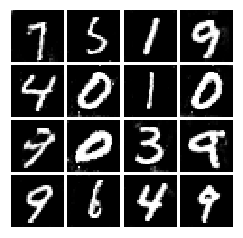


Iter: 11000, D: 0.8458, G:3.221
Iter: 11050, D: 0.7597, G:3.304
Iter: 11100, D: 0.7106, G:3.562
Iter: 11150, D: 0.7133, G:4.359
Iter: 11200, D: 0.7136, G:3.292


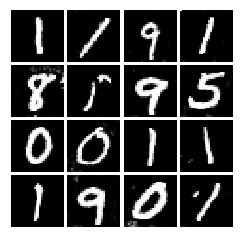


Iter: 11250, D: 0.8703, G:3.549
Iter: 11300, D: 0.7396, G:3.176
Iter: 11350, D: 0.8402, G:4.453
Iter: 11400, D: 0.7194, G:2.997
Iter: 11450, D: 0.6689, G:3.803


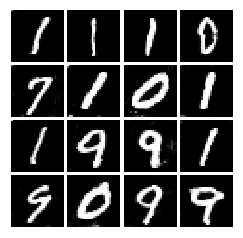


Iter: 11500, D: 0.744, G:3.535
Iter: 11550, D: 0.8302, G:4.244
Iter: 11600, D: 0.7854, G:4.585
Iter: 11650, D: 0.69, G:3.107
Iter: 11700, D: 0.7417, G:4.508


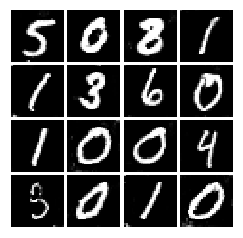


Iter: 11750, D: 0.6555, G:3.017
Iter: 11800, D: 0.8035, G:5.195
Iter: 11850, D: 0.7324, G:3.055
Iter: 11900, D: 0.7867, G:3.901
Iter: 11950, D: 0.7881, G:3.274


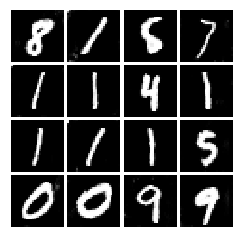


Iter: 12000, D: 0.9324, G:3.635
Iter: 12050, D: 0.7585, G:3.458
Iter: 12100, D: 0.8149, G:3.966
Iter: 12150, D: 0.7133, G:3.712
Iter: 12200, D: 0.7135, G:3.618


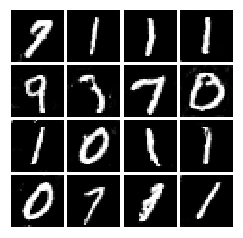


Iter: 12250, D: 0.7025, G:4.303
Iter: 12300, D: 0.7571, G:4.589
Iter: 12350, D: 0.8157, G:5.593
Iter: 12400, D: 0.8165, G:2.352
Iter: 12450, D: 0.7928, G:3.039


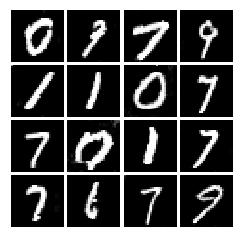


Iter: 12500, D: 0.8189, G:4.042
Iter: 12550, D: 0.7721, G:3.441
Iter: 12600, D: 0.6187, G:3.959
Iter: 12650, D: 0.6998, G:4.172
Iter: 12700, D: 0.6876, G:3.602


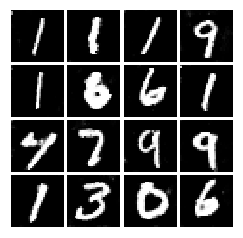


Iter: 12750, D: 0.779, G:3.813
Iter: 12800, D: 0.7781, G:4.838
Iter: 12850, D: 0.7553, G:3.903
Iter: 12900, D: 0.7777, G:4.099
Iter: 12950, D: 0.7267, G:4.065


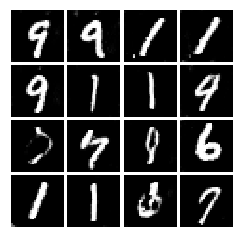


Iter: 13000, D: 0.629, G:3.583
Iter: 13050, D: 0.6631, G:4.558
Iter: 13100, D: 0.7157, G:4.395
Iter: 13150, D: 0.7839, G:4.692
Iter: 13200, D: 0.6979, G:3.815


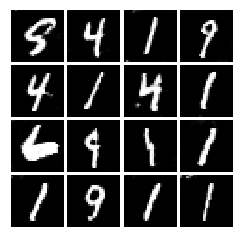


Iter: 13250, D: 0.768, G:4.764
Iter: 13300, D: 0.6709, G:4.236
Iter: 13350, D: 0.7255, G:3.833
Iter: 13400, D: 1.016, G:4.608
Iter: 13450, D: 0.6105, G:4.034


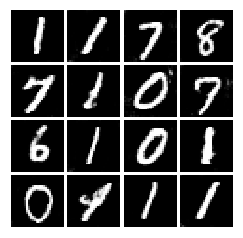


Iter: 13500, D: 0.6401, G:4.104
Iter: 13550, D: 0.7979, G:4.094
Iter: 13600, D: 0.7656, G:3.981
Iter: 13650, D: 0.6672, G:3.609
Iter: 13700, D: 0.6848, G:4.078


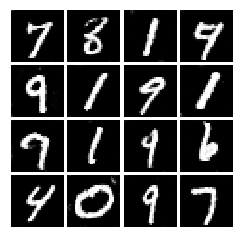


Iter: 13750, D: 0.6114, G:3.783
Iter: 13800, D: 0.7334, G:4.265
Iter: 13850, D: 1.12, G:4.119
Iter: 13900, D: 0.6426, G:3.094
Iter: 13950, D: 0.5866, G:4.1


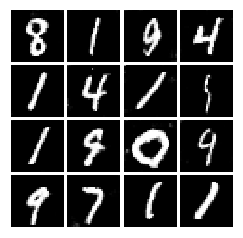


Iter: 14000, D: 0.6952, G:3.733
Iter: 14050, D: 0.7063, G:4.201
Iter: 14100, D: 0.6472, G:4.418
Iter: 14150, D: 0.6113, G:3.463
Iter: 14200, D: 0.6867, G:3.82


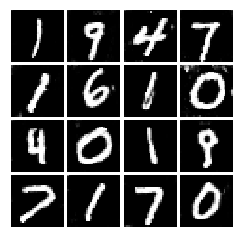


Iter: 14250, D: 0.7569, G:3.313
Iter: 14300, D: 0.5892, G:3.441
Iter: 14350, D: 0.6084, G:4.591
Iter: 14400, D: 0.5876, G:3.896
Iter: 14450, D: 0.6039, G:4.238


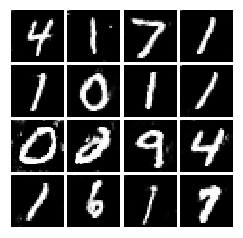


Iter: 14500, D: 0.634, G:4.322
Iter: 14550, D: 0.7571, G:3.603
Iter: 14600, D: 0.6116, G:3.978
Iter: 14650, D: 0.6319, G:3.867
Iter: 14700, D: 0.6833, G:4.305


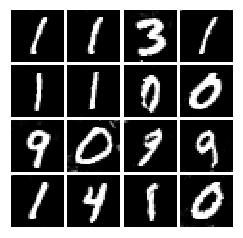


Iter: 14750, D: 0.6394, G:4.06
Iter: 14800, D: 0.7026, G:4.209
Iter: 14850, D: 0.6316, G:4.584
Iter: 14900, D: 0.62, G:4.447
Iter: 14950, D: 0.6307, G:4.93


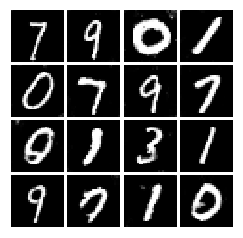


Iter: 15000, D: 0.9936, G:3.982
Iter: 15050, D: 0.6365, G:3.408
Iter: 15100, D: 1.186, G:4.421
Iter: 15150, D: 0.6169, G:4.318
Iter: 15200, D: 0.6179, G:4.573


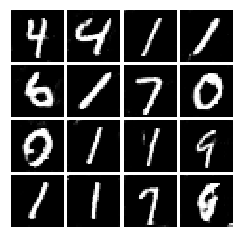


Iter: 15250, D: 0.6175, G:4.981
Iter: 15300, D: 0.53, G:5.233
Iter: 15350, D: 0.621, G:3.852
Iter: 15400, D: 0.5992, G:3.436
Iter: 15450, D: 0.5827, G:4.495


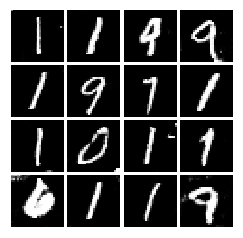


Iter: 15500, D: 0.6313, G:3.856
Iter: 15550, D: 0.6589, G:4.974
Iter: 15600, D: 0.6295, G:4.783
Iter: 15650, D: 0.6909, G:5.291
Iter: 15700, D: 0.6705, G:5.08


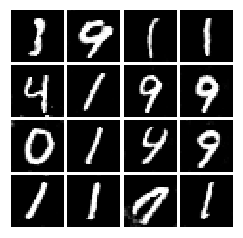


Iter: 15750, D: 0.6174, G:3.778
Iter: 15800, D: 0.6718, G:4.435
Iter: 15850, D: 0.6895, G:3.662
Iter: 15900, D: 0.5661, G:4.61
Iter: 15950, D: 0.5986, G:3.834


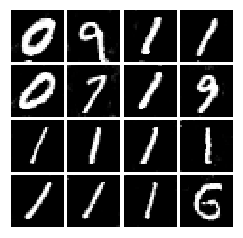


Iter: 16000, D: 0.6294, G:5.083
Iter: 16050, D: 0.5425, G:4.558
Iter: 16100, D: 0.5914, G:4.128
Iter: 16150, D: 0.5565, G:5.223
Iter: 16200, D: 0.5884, G:4.957


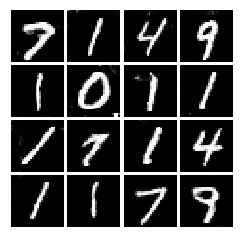


Iter: 16250, D: 0.6066, G:4.69
Iter: 16300, D: 0.6183, G:4.77
Iter: 16350, D: 0.7428, G:5.367
Iter: 16400, D: 0.5939, G:3.776
Iter: 16450, D: 0.6694, G:5.505


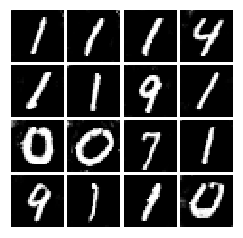


Iter: 16500, D: 0.6321, G:5.596
Iter: 16550, D: 0.645, G:5.06
Iter: 16600, D: 0.5545, G:4.236
Iter: 16650, D: 0.6433, G:5.013
Iter: 16700, D: 0.5655, G:4.765


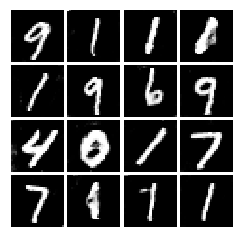


Iter: 16750, D: 0.6802, G:3.833
Iter: 16800, D: 0.6646, G:4.923
Iter: 16850, D: 0.7014, G:4.327
Iter: 16900, D: 0.5062, G:5.11
Iter: 16950, D: 0.6138, G:4.934


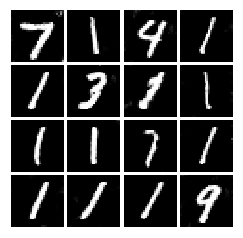


Iter: 17000, D: 0.5839, G:4.41
Iter: 17050, D: 0.5791, G:5.531
Iter: 17100, D: 0.6565, G:3.61
Iter: 17150, D: 0.5897, G:4.513
Iter: 17200, D: 0.5843, G:5.019


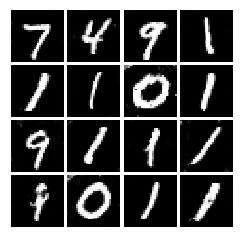


Iter: 17250, D: 0.5215, G:5.093
Iter: 17300, D: 0.6336, G:4.506
Iter: 17350, D: 0.6882, G:4.347
Iter: 17400, D: 0.6375, G:5.229
Iter: 17450, D: 0.6477, G:4.195


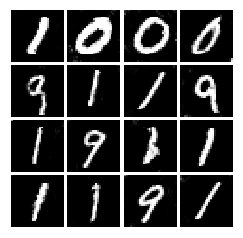


Iter: 17500, D: 0.6284, G:4.259
Iter: 17550, D: 0.5568, G:5.213
Iter: 17600, D: 0.5046, G:5.222
Iter: 17650, D: 0.5537, G:4.114
Iter: 17700, D: 0.5186, G:4.879


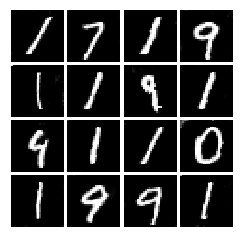


Iter: 17750, D: 0.6563, G:4.452
Iter: 17800, D: 0.5629, G:4.919
Iter: 17850, D: 0.5256, G:5.511
Iter: 17900, D: 0.6457, G:5.463
Iter: 17950, D: 0.6697, G:4.87


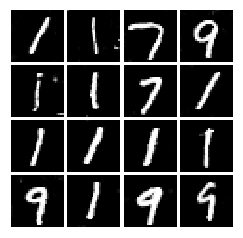


Iter: 18000, D: 0.5901, G:5.085
Iter: 18050, D: 0.5812, G:5.15
Iter: 18100, D: 0.5675, G:4.696
Iter: 18150, D: 0.5067, G:5.074
Iter: 18200, D: 0.5404, G:6.509


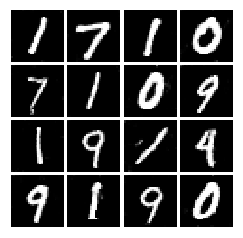


Iter: 18250, D: 0.5444, G:5.628
Iter: 18300, D: 0.5598, G:4.636
Iter: 18350, D: 0.5221, G:4.986
Iter: 18400, D: 0.5549, G:5.658
Iter: 18450, D: 0.6853, G:5.827


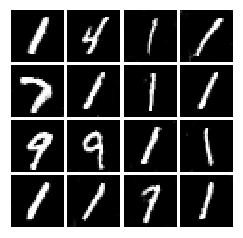


Iter: 18500, D: 0.6296, G:5.519
Iter: 18550, D: 0.5732, G:5.317
Iter: 18600, D: 0.5545, G:5.82
Iter: 18650, D: 0.5179, G:4.502
Iter: 18700, D: 0.748, G:3.967


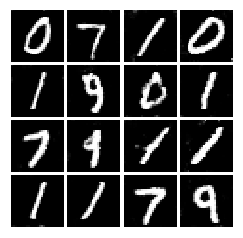


Iter: 18750, D: 0.5872, G:5.898
Iter: 18800, D: 0.5526, G:5.303
Iter: 18850, D: 0.5085, G:4.895
Iter: 18900, D: 0.5514, G:4.038
Iter: 18950, D: 0.5328, G:6.998


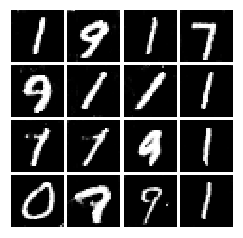


Iter: 19000, D: 0.5307, G:4.273
Iter: 19050, D: 0.5145, G:5.378
Iter: 19100, D: 0.4679, G:5.387
Iter: 19150, D: 0.5391, G:4.97
Iter: 19200, D: 0.6039, G:4.101


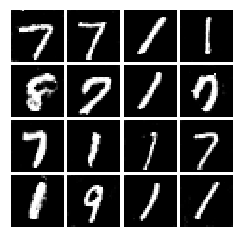


Iter: 19250, D: 0.5448, G:5.753
Iter: 19300, D: 0.5289, G:4.411
Iter: 19350, D: 0.5221, G:4.794
Iter: 19400, D: 0.5179, G:5.003
Iter: 19450, D: 0.5261, G:5.293


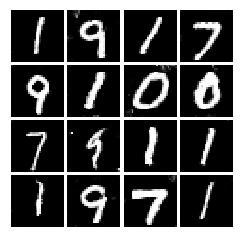


Iter: 19500, D: 0.4821, G:5.51
Iter: 19550, D: 0.5784, G:6.403
Iter: 19600, D: 0.6234, G:6.488
Iter: 19650, D: 0.5365, G:4.562
Iter: 19700, D: 0.4768, G:5.558


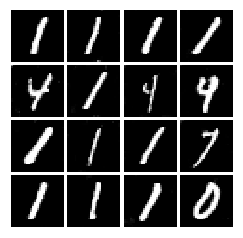


Iter: 19750, D: 0.662, G:3.618
Iter: 19800, D: 0.5212, G:5.482
Iter: 19850, D: 0.479, G:5.514
Iter: 19900, D: 0.5185, G:6.085
Iter: 19950, D: 0.5034, G:5.715


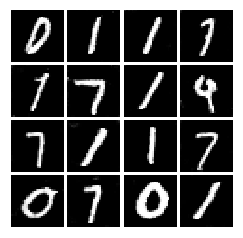


Iter: 20000, D: 0.5009, G:4.936
Iter: 20050, D: 0.5135, G:5.796
Iter: 20100, D: 0.5703, G:4.733
Iter: 20150, D: 0.4543, G:6.771
Iter: 20200, D: 0.5002, G:5.887


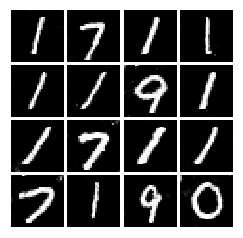


Iter: 20250, D: 0.5864, G:6.654
Iter: 20300, D: 0.4737, G:6.704
Iter: 20350, D: 0.5151, G:5.535
Iter: 20400, D: 0.5427, G:6.275
Iter: 20450, D: 0.4754, G:5.432


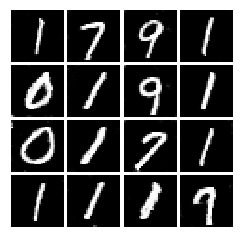


Iter: 20500, D: 0.5183, G:5.925
Iter: 20550, D: 0.5312, G:5.526
Iter: 20600, D: 0.5388, G:5.325
Iter: 20650, D: 0.5212, G:5.467
Iter: 20700, D: 0.4825, G:5.664


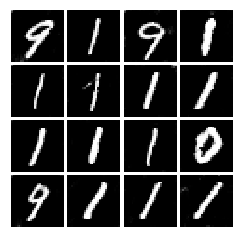


Iter: 20750, D: 0.5261, G:6.155
Iter: 20800, D: 0.4738, G:5.649
Iter: 20850, D: 0.5207, G:5.523
Iter: 20900, D: 0.5042, G:6.261
Iter: 20950, D: 0.4944, G:6.421


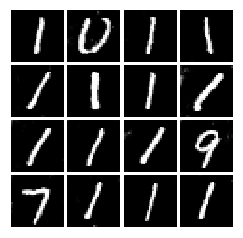


Iter: 21000, D: 0.4719, G:6.167
Iter: 21050, D: 0.4538, G:6.516
Iter: 21100, D: 0.5094, G:5.421
Iter: 21150, D: 0.4693, G:6.047
Iter: 21200, D: 0.5404, G:4.93


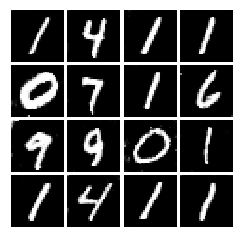


Iter: 21250, D: 0.5187, G:6.137
Iter: 21300, D: 0.5368, G:5.418
Iter: 21350, D: 0.4798, G:6.575
Iter: 21400, D: 0.4778, G:5.959
Iter: 21450, D: 0.4876, G:6.727


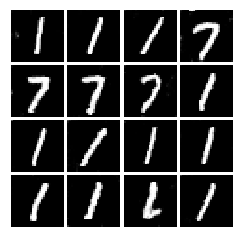


Iter: 21500, D: 0.5624, G:5.851
Iter: 21550, D: 0.5547, G:5.849
Iter: 21600, D: 0.5212, G:5.679
Iter: 21650, D: 0.5218, G:5.206
Iter: 21700, D: 0.4494, G:6.713


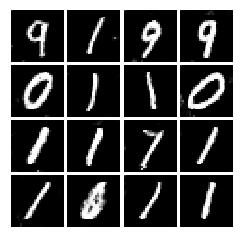


Iter: 21750, D: 0.5516, G:5.414
Iter: 21800, D: 0.5333, G:6.43
Iter: 21850, D: 0.5076, G:5.583
Iter: 21900, D: 0.5634, G:5.672
Iter: 21950, D: 0.5508, G:5.765


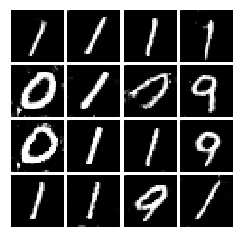


Iter: 22000, D: 0.5421, G:3.931
Iter: 22050, D: 0.4645, G:5.463
Iter: 22100, D: 0.466, G:6.487
Iter: 22150, D: 0.4995, G:6.07
Iter: 22200, D: 0.4832, G:6.285


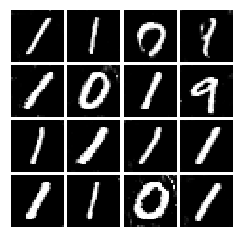


Iter: 22250, D: 0.4611, G:6.094
Iter: 22300, D: 0.5047, G:5.582
Iter: 22350, D: 0.5338, G:6.523
Iter: 22400, D: 0.4042, G:6.707
Iter: 22450, D: 0.5325, G:5.766


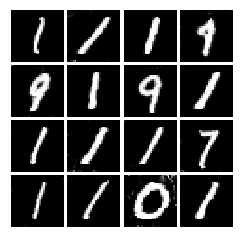


Iter: 22500, D: 0.4316, G:5.908
Iter: 22550, D: 0.5136, G:5.413
Iter: 22600, D: 0.4736, G:5.537
Iter: 22650, D: 0.4578, G:5.92
Iter: 22700, D: 0.5078, G:5.81


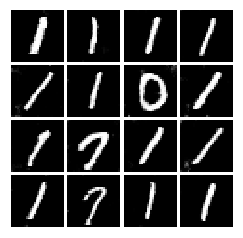


Iter: 22750, D: 0.5727, G:6.022
Iter: 22800, D: 0.4558, G:5.823
Iter: 22850, D: 0.4744, G:5.901
Iter: 22900, D: 0.4561, G:6.573
Iter: 22950, D: 0.5105, G:5.862


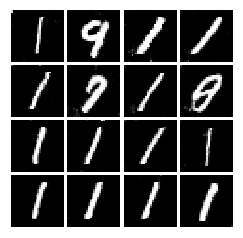


Iter: 23000, D: 0.4978, G:6.927
Iter: 23050, D: 0.6054, G:7.642
Iter: 23100, D: 0.5483, G:5.864
Iter: 23150, D: 0.451, G:5.723
Iter: 23200, D: 0.7575, G:4.318


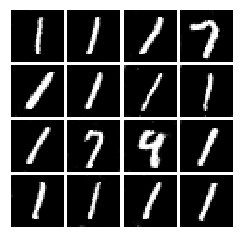


Iter: 23250, D: 0.4777, G:5.88
Iter: 23300, D: 0.4667, G:6.946
Iter: 23350, D: 0.4322, G:6.266
Iter: 23400, D: 0.4789, G:5.836
Iter: 23450, D: 0.4286, G:5.98


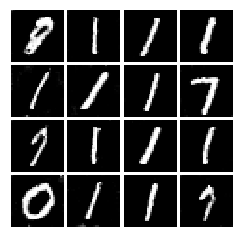


Iter: 23500, D: 0.4381, G:6.584
Iter: 23550, D: 0.4343, G:6.71
Iter: 23600, D: 0.4934, G:4.872
Iter: 23650, D: 0.5102, G:6.289
Iter: 23700, D: 0.4665, G:5.696


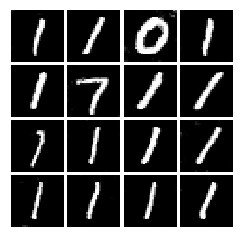


Iter: 23750, D: 0.417, G:6.246
Iter: 23800, D: 0.4147, G:7.363
Iter: 23850, D: 0.5419, G:6.265
Iter: 23900, D: 0.4236, G:7.005
Iter: 23950, D: 0.4626, G:7.0


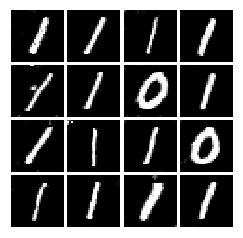


Iter: 24000, D: 0.4719, G:6.986
Iter: 24050, D: 0.4999, G:6.914
Iter: 24100, D: 0.4498, G:6.009
Iter: 24150, D: 0.5594, G:6.947
Iter: 24200, D: 0.5127, G:6.162


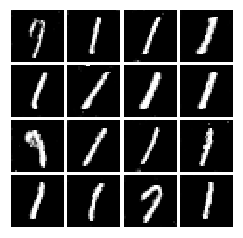


Iter: 24250, D: 0.4518, G:6.41
Iter: 24300, D: 0.4352, G:6.922
Iter: 24350, D: 0.4445, G:6.025
Iter: 24400, D: 0.4804, G:7.141
Iter: 24450, D: 0.4797, G:5.974


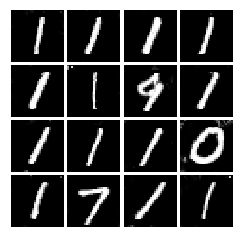


Iter: 24500, D: 0.4801, G:6.217
Iter: 24550, D: 0.4588, G:5.477
Iter: 24600, D: 0.4632, G:6.249
Iter: 24650, D: 0.6031, G:6.083
Iter: 24700, D: 0.5021, G:6.102


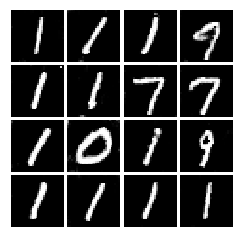


Iter: 24750, D: 0.4259, G:6.862
Iter: 24800, D: 0.4253, G:5.906
Iter: 24850, D: 0.4309, G:6.693
Iter: 24900, D: 0.4363, G:7.035
Iter: 24950, D: 0.4839, G:6.899


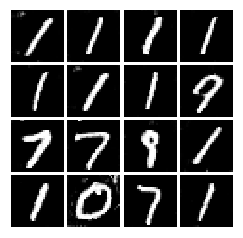


Iter: 25000, D: 0.5267, G:6.167
Iter: 25050, D: 0.4659, G:6.639
Iter: 25100, D: 0.4614, G:5.621
Iter: 25150, D: 0.4163, G:6.194
Iter: 25200, D: 0.4296, G:6.466


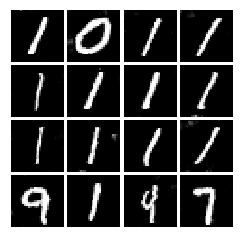


Iter: 25250, D: 0.459, G:6.744
Iter: 25300, D: 0.4002, G:6.049
Iter: 25350, D: 0.4977, G:7.233
Iter: 25400, D: 0.4313, G:6.291
Iter: 25450, D: 0.444, G:6.846


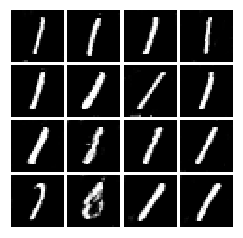


Iter: 25500, D: 0.485, G:5.419
Iter: 25550, D: 0.4358, G:6.951
Iter: 25600, D: 0.4412, G:6.474
Iter: 25650, D: 0.4489, G:6.541
Iter: 25700, D: 0.4012, G:7.547


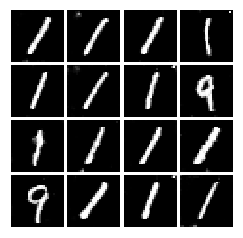


Iter: 25750, D: 0.5077, G:6.861
Iter: 25800, D: 0.4335, G:6.47
Iter: 25850, D: 0.4731, G:6.282
Iter: 25900, D: 0.4024, G:7.139
Iter: 25950, D: 0.4244, G:6.654


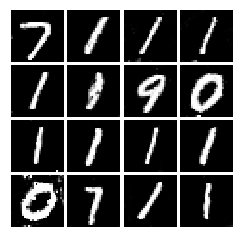


Iter: 26000, D: 0.4613, G:6.914
Iter: 26050, D: 0.4216, G:7.126
Iter: 26100, D: 0.4148, G:7.092
Iter: 26150, D: 0.4172, G:7.716
Iter: 26200, D: 0.4713, G:5.743


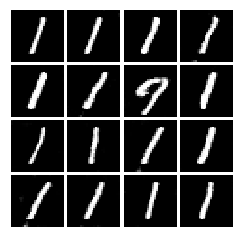


Iter: 26250, D: 0.4907, G:6.908
Iter: 26300, D: 0.4619, G:6.925
Iter: 26350, D: 0.5203, G:7.189
Iter: 26400, D: 0.4516, G:6.746
Iter: 26450, D: 0.4037, G:6.925


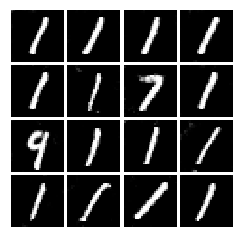


Iter: 26500, D: 0.5136, G:7.221
Iter: 26550, D: 0.4511, G:7.245
Iter: 26600, D: 0.4576, G:6.361
Iter: 26650, D: 0.4146, G:8.58
Iter: 26700, D: 0.3995, G:6.56


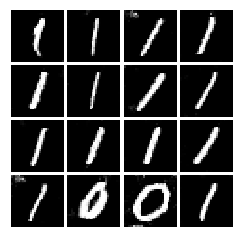


Iter: 26750, D: 0.4097, G:6.573
Iter: 26800, D: 0.4148, G:6.539
Iter: 26850, D: 0.4506, G:7.549
Iter: 26900, D: 0.4216, G:7.284
Iter: 26950, D: 0.4935, G:7.539


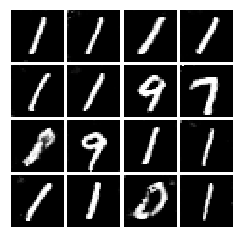


Iter: 27000, D: 0.3977, G:7.122
Iter: 27050, D: 0.4015, G:7.36
Iter: 27100, D: 0.4389, G:7.564
Iter: 27150, D: 0.4379, G:6.946
Iter: 27200, D: 0.4457, G:6.897


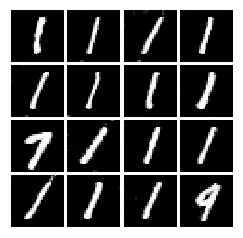


Iter: 27250, D: 0.4003, G:7.88
Iter: 27300, D: 0.4153, G:7.07
Iter: 27350, D: 0.4398, G:7.904
Iter: 27400, D: 0.4459, G:7.305
Iter: 27450, D: 0.4191, G:7.444


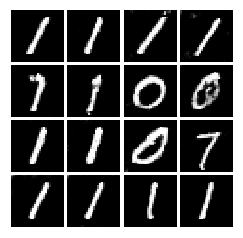


Iter: 27500, D: 0.4375, G:7.891
Iter: 27550, D: 0.4709, G:8.127
Iter: 27600, D: 0.3943, G:6.985
Iter: 27650, D: 0.4747, G:7.092
Iter: 27700, D: 0.4187, G:7.654


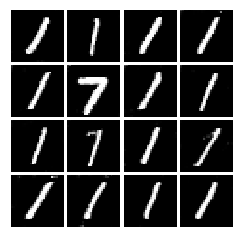


Iter: 27750, D: 0.4267, G:7.504
Iter: 27800, D: 0.4451, G:6.855
Iter: 27850, D: 0.4522, G:8.241
Iter: 27900, D: 0.4102, G:7.045
Iter: 27950, D: 0.4633, G:7.175


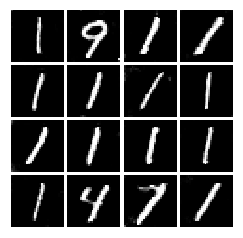


Iter: 28000, D: 0.4918, G:6.741
Iter: 28050, D: 0.45, G:8.581
Iter: 28100, D: 0.4077, G:7.265
Iter: 28150, D: 0.418, G:7.775
Iter: 28200, D: 0.4445, G:7.292


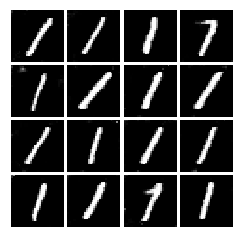


Iter: 28250, D: 0.4506, G:7.834
Iter: 28300, D: 0.4487, G:7.18
Iter: 28350, D: 0.4361, G:7.562
Iter: 28400, D: 0.4115, G:7.64
Iter: 28450, D: 0.4069, G:6.587


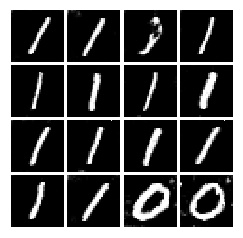


Iter: 28500, D: 0.421, G:7.472
Iter: 28550, D: 0.4269, G:7.365
Iter: 28600, D: 0.4106, G:8.296
Iter: 28650, D: 0.4116, G:7.225
Iter: 28700, D: 0.3962, G:8.018


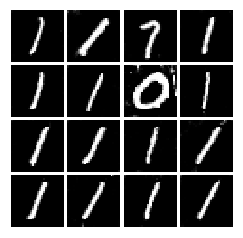


Iter: 28750, D: 0.4009, G:7.22
Iter: 28800, D: 0.3919, G:8.899
Iter: 28850, D: 0.4205, G:7.77
Iter: 28900, D: 0.4802, G:8.452
Iter: 28950, D: 0.4097, G:8.428


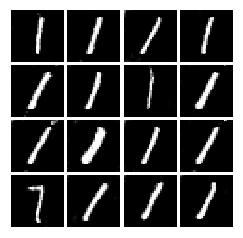


Iter: 29000, D: 0.4151, G:7.578
Iter: 29050, D: 0.4069, G:8.59
Iter: 29100, D: 0.3917, G:7.76
Iter: 29150, D: 0.4189, G:7.37
Iter: 29200, D: 0.4543, G:6.542


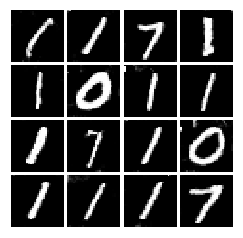


Iter: 29250, D: 0.3905, G:7.657
Iter: 29300, D: 0.4053, G:7.47
Iter: 29350, D: 0.3944, G:6.718
Iter: 29400, D: 0.4359, G:7.133
Iter: 29450, D: 0.4572, G:6.404


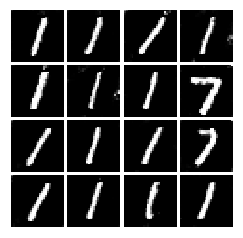


Iter: 29500, D: 0.4348, G:7.805
Iter: 29550, D: 0.3935, G:7.638
Iter: 29600, D: 0.397, G:7.16
Iter: 29650, D: 0.4732, G:7.561
Iter: 29700, D: 0.3997, G:7.588


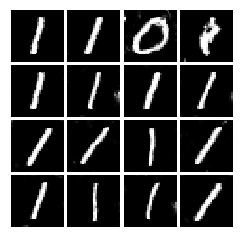


Iter: 29750, D: 0.4023, G:8.211
Iter: 29800, D: 0.4004, G:9.143
Iter: 29850, D: 0.4559, G:7.932
Iter: 29900, D: 0.4681, G:8.228
Iter: 29950, D: 0.3757, G:9.423


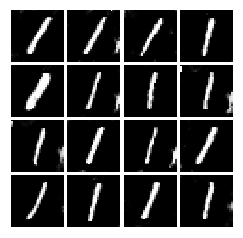


Iter: 30000, D: 0.3953, G:7.462
Iter: 30050, D: 0.3836, G:8.542
Iter: 30100, D: 0.4537, G:7.021
Iter: 30150, D: 0.5023, G:8.146
Iter: 30200, D: 0.3745, G:9.0


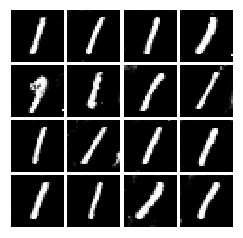


Iter: 30250, D: 0.4053, G:8.391
Iter: 30300, D: 0.4051, G:9.299
Iter: 30350, D: 0.4298, G:7.315
Iter: 30400, D: 0.4224, G:8.424
Iter: 30450, D: 0.4109, G:9.049


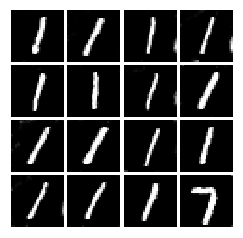


Iter: 30500, D: 0.4313, G:9.772
Iter: 30550, D: 0.432, G:8.083
Iter: 30600, D: 0.4868, G:9.009
Iter: 30650, D: 0.4484, G:7.851
Iter: 30700, D: 0.4033, G:8.863


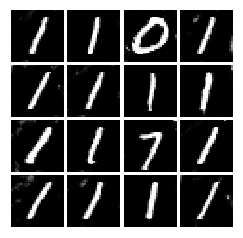


Iter: 30750, D: 0.4, G:9.359
Iter: 30800, D: 0.4087, G:8.937
Iter: 30850, D: 0.4534, G:7.138
Iter: 30900, D: 0.387, G:8.522
Iter: 30950, D: 0.412, G:8.876


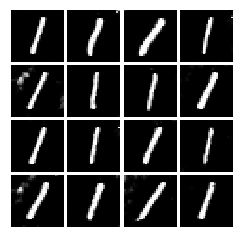


Iter: 31000, D: 0.4148, G:8.609
Iter: 31050, D: 0.4032, G:8.93
Iter: 31100, D: 0.4499, G:8.096
Iter: 31150, D: 0.4045, G:8.515
Iter: 31200, D: 0.4265, G:7.391


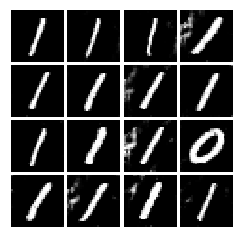


Iter: 31250, D: 0.3806, G:9.165
Iter: 31300, D: 0.4357, G:6.778
Iter: 31350, D: 0.3846, G:9.712
Iter: 31400, D: 0.3966, G:8.124
Iter: 31450, D: 0.3952, G:8.387


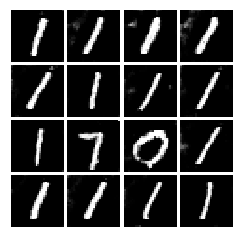


Iter: 31500, D: 0.3859, G:8.638
Iter: 31550, D: 0.39, G:7.646
Iter: 31600, D: 0.4031, G:7.41
Iter: 31650, D: 0.4462, G:9.186
Iter: 31700, D: 0.4133, G:7.705


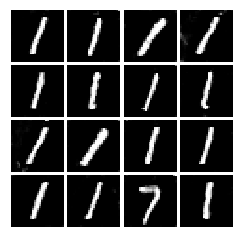


Iter: 31750, D: 0.3934, G:8.547
Iter: 31800, D: 0.375, G:7.612
Iter: 31850, D: 0.3929, G:7.871
Iter: 31900, D: 0.4118, G:8.439
Iter: 31950, D: 0.379, G:8.096


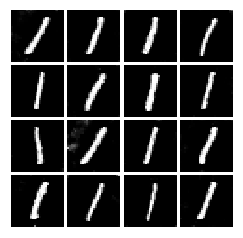


Iter: 32000, D: 0.3787, G:8.473
Iter: 32050, D: 0.3888, G:6.874
Iter: 32100, D: 0.3954, G:8.346
Iter: 32150, D: 0.4001, G:9.195
Iter: 32200, D: 0.4079, G:9.348


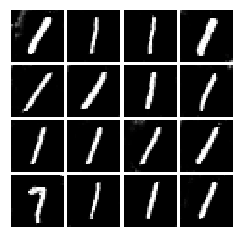


Iter: 32250, D: 0.3862, G:9.023
Iter: 32300, D: 0.4361, G:8.495
Iter: 32350, D: 0.3932, G:10.22
Iter: 32400, D: 0.4154, G:9.772
Iter: 32450, D: 0.4467, G:7.123


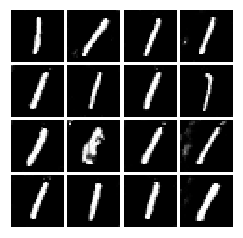


Iter: 32500, D: 0.4915, G:7.354
Iter: 32550, D: 0.4599, G:8.874
Iter: 32600, D: 0.393, G:9.415
Iter: 32650, D: 0.4199, G:8.749
Iter: 32700, D: 0.4276, G:9.11


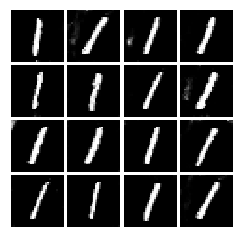


Iter: 32750, D: 0.3997, G:8.893
Iter: 32800, D: 0.3949, G:9.033
Iter: 32850, D: 0.379, G:8.449
Iter: 32900, D: 0.4144, G:9.423
Iter: 32950, D: 0.4243, G:9.58


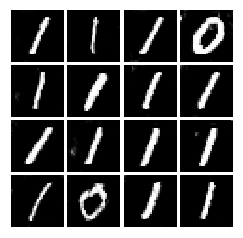


Iter: 33000, D: 0.4208, G:8.95
Iter: 33050, D: 0.4662, G:10.16
Iter: 33100, D: 0.411, G:9.144
Iter: 33150, D: 0.456, G:8.401
Iter: 33200, D: 0.4025, G:8.699


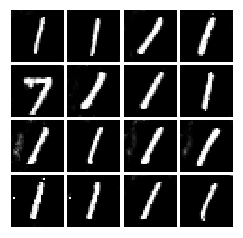


Iter: 33250, D: 0.4889, G:9.856
Iter: 33300, D: 0.4404, G:8.265
Iter: 33350, D: 0.4562, G:7.54
Iter: 33400, D: 0.5023, G:8.594
Iter: 33450, D: 0.4558, G:8.231


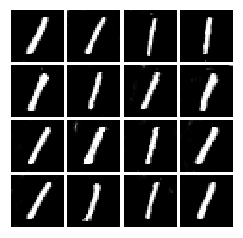


Iter: 33500, D: 0.4067, G:8.183
Iter: 33550, D: 0.4152, G:9.319
Iter: 33600, D: 0.4002, G:9.503
Iter: 33650, D: 0.373, G:9.22
Iter: 33700, D: 0.3822, G:10.28


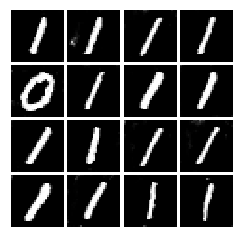


Iter: 33750, D: 0.5338, G:8.184
Iter: 33800, D: 0.3917, G:9.007
Iter: 33850, D: 0.3937, G:9.377
Iter: 33900, D: 0.3873, G:8.91
Iter: 33950, D: 0.3914, G:8.254


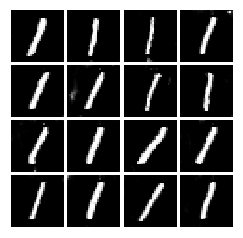


Iter: 34000, D: 0.5194, G:9.663
Iter: 34050, D: 0.3803, G:10.39
Iter: 34100, D: 0.3762, G:8.88
Iter: 34150, D: 0.4313, G:9.44
Iter: 34200, D: 0.377, G:9.846


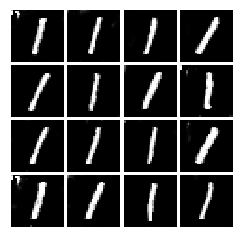


Iter: 34250, D: 0.3929, G:10.91
Iter: 34300, D: 0.3788, G:9.48
Iter: 34350, D: 0.4045, G:7.277
Iter: 34400, D: 0.4337, G:8.141
Iter: 34450, D: 0.4129, G:11.81


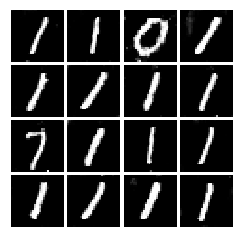


Iter: 34500, D: 0.4342, G:7.614
Iter: 34550, D: 0.4149, G:8.54
Iter: 34600, D: 0.4033, G:9.697
Iter: 34650, D: 0.3798, G:9.566
Iter: 34700, D: 0.3774, G:9.638


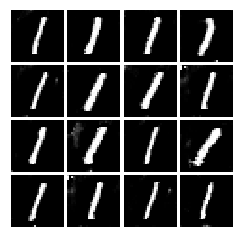


Iter: 34750, D: 0.3692, G:9.455
Iter: 34800, D: 0.3951, G:10.5
Iter: 34850, D: 0.4054, G:9.862
Iter: 34900, D: 0.3722, G:10.72
Iter: 34950, D: 0.4303, G:9.603


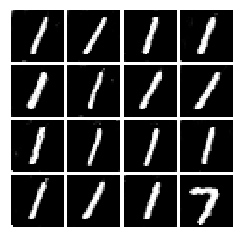


Iter: 35000, D: 0.4297, G:9.974
Iter: 35050, D: 0.3874, G:8.782
Iter: 35100, D: 0.4021, G:9.16
Iter: 35150, D: 0.4549, G:8.404
Iter: 35200, D: 0.4158, G:9.552


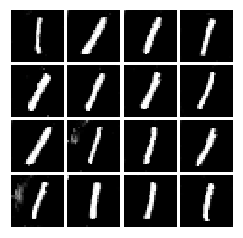


Iter: 35250, D: 0.4, G:11.37
Iter: 35300, D: 0.3876, G:8.816
Iter: 35350, D: 0.3905, G:8.634
Iter: 35400, D: 0.4315, G:8.42
Iter: 35450, D: 0.4073, G:8.491


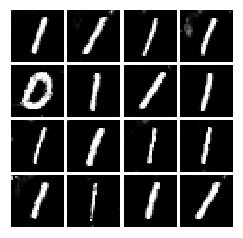


Iter: 35500, D: 0.3747, G:9.36
Iter: 35550, D: 0.4259, G:9.867
Iter: 35600, D: 0.3742, G:9.057
Iter: 35650, D: 0.3811, G:9.522
Iter: 35700, D: 0.391, G:9.445


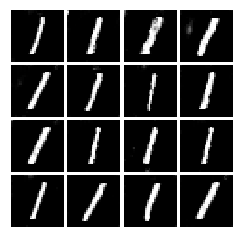


Iter: 35750, D: 0.3948, G:7.902
Iter: 35800, D: 0.3787, G:8.548
Iter: 35850, D: 0.3868, G:9.268
Iter: 35900, D: 0.409, G:9.425
Iter: 35950, D: 0.398, G:8.521


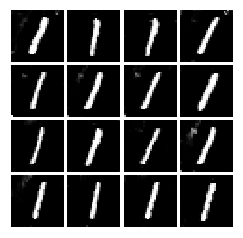


Iter: 36000, D: 0.3956, G:10.36
Iter: 36050, D: 0.3768, G:9.509
Iter: 36100, D: 0.3842, G:9.118
Iter: 36150, D: 0.408, G:9.616
Iter: 36200, D: 0.4542, G:11.35


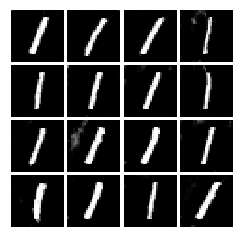


Iter: 36250, D: 0.4059, G:8.245
Iter: 36300, D: 0.3765, G:9.188
Iter: 36350, D: 0.3879, G:10.41
Iter: 36400, D: 0.4161, G:9.302
Iter: 36450, D: 0.4274, G:8.613


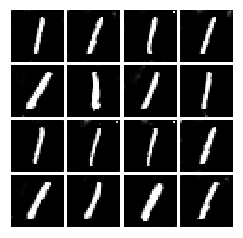


Iter: 36500, D: 0.3775, G:9.951
Iter: 36550, D: 0.3779, G:9.4
Iter: 36600, D: 0.3824, G:9.221
Iter: 36650, D: 0.4113, G:8.509
Iter: 36700, D: 0.4136, G:10.49


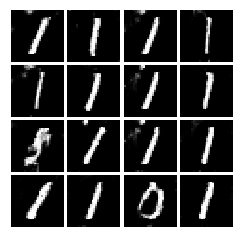


Iter: 36750, D: 0.4367, G:10.16
Iter: 36800, D: 0.3699, G:12.9
Iter: 36850, D: 0.3896, G:9.152
Iter: 36900, D: 0.3933, G:9.521
Iter: 36950, D: 0.42, G:9.149


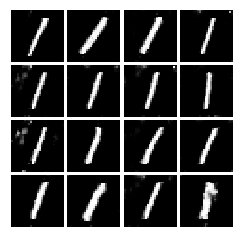


Iter: 37000, D: 0.4026, G:10.05
Iter: 37050, D: 0.3835, G:10.92
Iter: 37100, D: 0.3823, G:11.11
Iter: 37150, D: 0.389, G:9.396
Iter: 37200, D: 0.6639, G:10.23


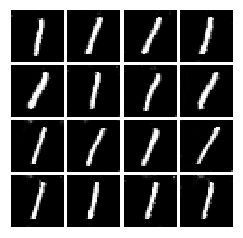


Iter: 37250, D: 0.3812, G:8.611
Iter: 37300, D: 0.4002, G:9.093
Iter: 37350, D: 0.4043, G:11.08
Iter: 37400, D: 0.3721, G:11.17
Iter: 37450, D: 0.3813, G:8.178


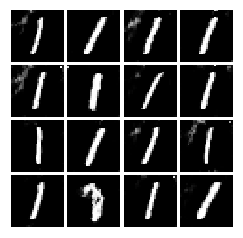


Iter: 37500, D: 0.3949, G:8.967
Iter: 37550, D: 0.3717, G:11.65
Iter: 37600, D: 0.3937, G:9.301
Iter: 37650, D: 0.4683, G:8.736
Iter: 37700, D: 0.387, G:12.95


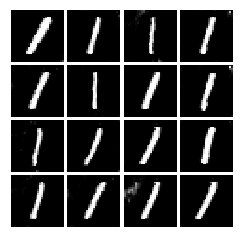


Iter: 37750, D: 0.4614, G:8.388
Iter: 37800, D: 0.3815, G:10.53
Iter: 37850, D: 0.3719, G:10.91
Iter: 37900, D: 0.3966, G:9.09
Iter: 37950, D: 0.4073, G:8.794


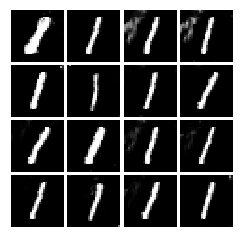


Iter: 38000, D: 0.3784, G:9.395
Iter: 38050, D: 0.381, G:11.54
Iter: 38100, D: 0.3869, G:10.99
Iter: 38150, D: 0.3745, G:9.283
Iter: 38200, D: 0.3801, G:10.01


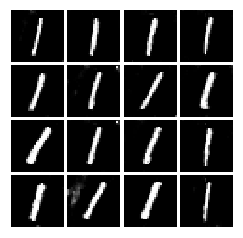


Iter: 38250, D: 0.4007, G:9.435
Iter: 38300, D: 0.3779, G:10.16
Iter: 38350, D: 0.3724, G:8.687
Iter: 38400, D: 0.4559, G:9.183
Iter: 38450, D: 0.4479, G:9.021


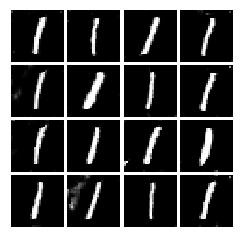


Iter: 38500, D: 0.3802, G:8.189
Iter: 38550, D: 0.4085, G:10.5
Iter: 38600, D: 0.3741, G:8.701
Iter: 38650, D: 0.3742, G:8.759
Iter: 38700, D: 0.3976, G:12.56


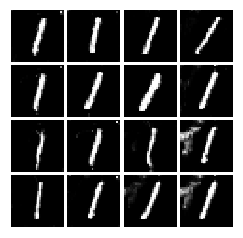


Iter: 38750, D: 0.3707, G:10.25
Iter: 38800, D: 0.4145, G:12.04
Iter: 38850, D: 0.3916, G:9.957
Iter: 38900, D: 0.3963, G:8.888
Iter: 38950, D: 0.3853, G:10.71


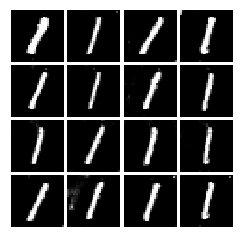


Iter: 39000, D: 0.3687, G:9.813
Iter: 39050, D: 0.4257, G:10.34
Iter: 39100, D: 0.4756, G:9.557
Iter: 39150, D: 0.4193, G:10.99
Iter: 39200, D: 0.3871, G:11.06


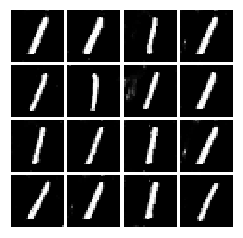


Iter: 39250, D: 0.3924, G:10.85
Iter: 39300, D: 0.375, G:9.824
Iter: 39350, D: 0.371, G:10.42
Iter: 39400, D: 0.3953, G:10.76
Iter: 39450, D: 0.3704, G:11.93


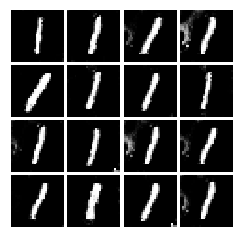


Iter: 39500, D: 0.3916, G:9.736
Iter: 39550, D: 0.5095, G:8.777
Iter: 39600, D: 0.3679, G:10.85
Iter: 39650, D: 0.3715, G:12.39
Iter: 39700, D: 0.4347, G:12.17


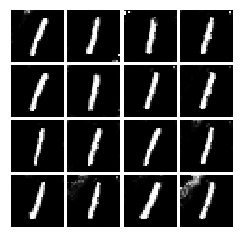


Iter: 39750, D: 0.3967, G:10.65
Iter: 39800, D: 0.3723, G:12.51
Iter: 39850, D: 0.3804, G:9.989
Iter: 39900, D: 0.3685, G:12.7
Iter: 39950, D: 0.3918, G:9.517


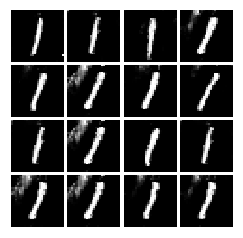


Iter: 40000, D: 0.404, G:8.139
Iter: 40050, D: 0.3686, G:10.08
Iter: 40100, D: 0.3824, G:12.24
Iter: 40150, D: 0.3827, G:9.675
Iter: 40200, D: 0.4587, G:8.209


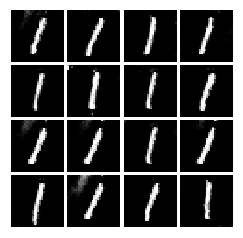


Iter: 40250, D: 0.3716, G:9.788
Iter: 40300, D: 0.3769, G:10.99
Iter: 40350, D: 0.3848, G:10.94
Iter: 40400, D: 0.38, G:9.86
Iter: 40450, D: 0.3714, G:11.48


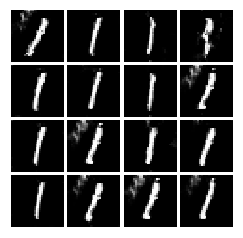


Iter: 40500, D: 0.4015, G:10.12
Iter: 40550, D: 0.372, G:8.552
Iter: 40600, D: 0.3858, G:9.611
Iter: 40650, D: 0.3907, G:11.43
Iter: 40700, D: 0.3761, G:10.58


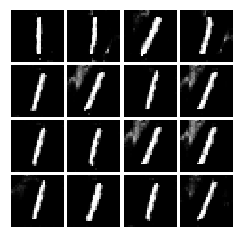


Iter: 40750, D: 0.3857, G:9.54
Iter: 40800, D: 0.3773, G:10.17
Iter: 40850, D: 0.3852, G:9.897
Iter: 40900, D: 0.3717, G:10.07
Iter: 40950, D: 0.3684, G:9.837


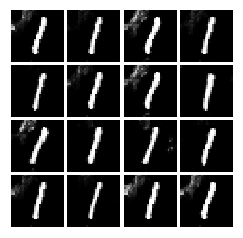


Iter: 41000, D: 0.3825, G:14.8
Iter: 41050, D: 0.3949, G:8.889
Iter: 41100, D: 0.3721, G:9.564
Iter: 41150, D: 0.4211, G:10.09
Iter: 41200, D: 0.3697, G:9.424


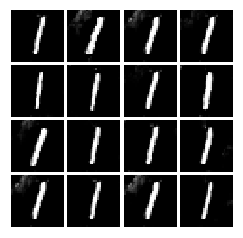


Iter: 41250, D: 0.3732, G:9.926
Iter: 41300, D: 0.3713, G:10.38
Iter: 41350, D: 0.3788, G:10.2
Iter: 41400, D: 0.386, G:11.99
Iter: 41450, D: 0.3682, G:11.62


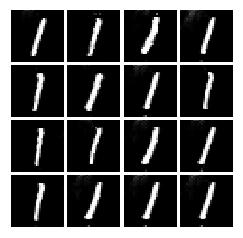


Iter: 41500, D: 0.3814, G:9.32
Iter: 41550, D: 0.3695, G:10.52
Iter: 41600, D: 0.381, G:15.99
Iter: 41650, D: 0.3766, G:9.646
Iter: 41700, D: 0.4651, G:8.251


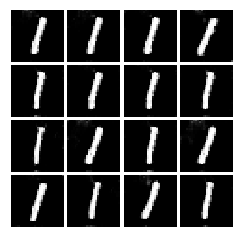


Iter: 41750, D: 0.3702, G:9.814
Iter: 41800, D: 0.4539, G:9.634
Iter: 41850, D: 0.4339, G:11.82
Iter: 41900, D: 0.3709, G:12.47
Iter: 41950, D: 0.6204, G:17.56


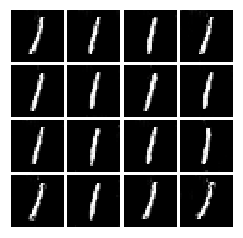


Iter: 42000, D: 0.3703, G:10.36
Iter: 42050, D: 0.3697, G:11.26
Iter: 42100, D: 0.4043, G:13.52
Iter: 42150, D: 0.3936, G:9.887
Iter: 42200, D: 0.3689, G:12.33


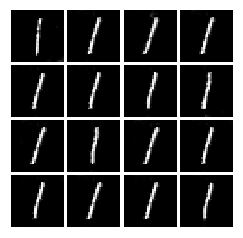


Iter: 42250, D: 0.3684, G:15.92
Iter: 42300, D: 2.201, G:21.16
Iter: 42350, D: 1.182, G:17.05
Iter: 42400, D: 0.6788, G:4.381
Iter: 42450, D: 0.7025, G:5.33


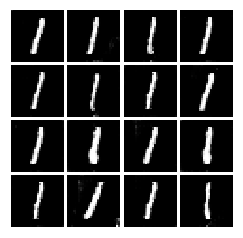


Iter: 42500, D: 0.5209, G:12.46
Iter: 42550, D: 0.5928, G:6.044
Iter: 42600, D: 0.4689, G:6.237
Iter: 42650, D: 0.4538, G:5.432
Iter: 42700, D: 0.5907, G:6.748


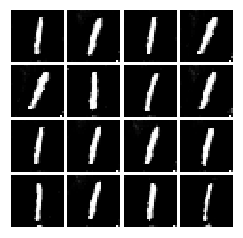


Iter: 42750, D: 0.5401, G:5.712
Iter: 42800, D: 0.5353, G:4.854
Iter: 42850, D: 0.419, G:6.319
Iter: 42900, D: 0.5068, G:6.373
Iter: 42950, D: 0.4812, G:5.776
Model saved in file: /tmp/model.ckpt
Final images


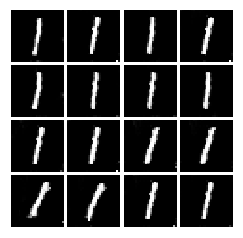

In [743]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    Dloss, Gloss = run_a_gan(sess,G_train_step,G_loss,\
                             D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=100)

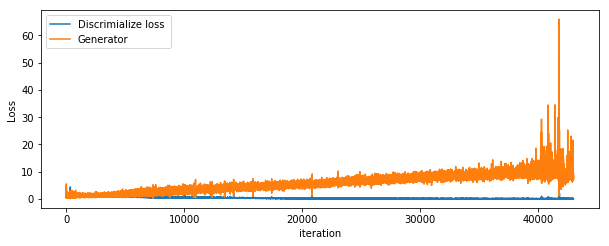

In [740]:
# Loss Visualization
plt.subplot(2, 1, 2)
plt.plot(Dloss )
plt.plot(Gloss)
plt.legend(['Discrimialize loss ', 'Generator'], loc='upper left')
#plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.show()

(96, 128, 96)
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


Original noise vector


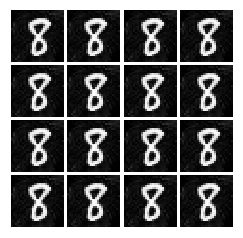

Modified noise vector, index = 0


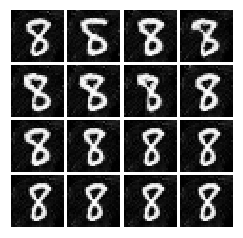

Modified noise vector, index = 1


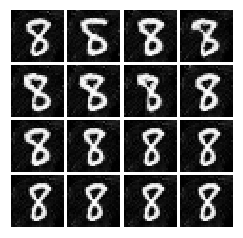

Modified noise vector, index = 2


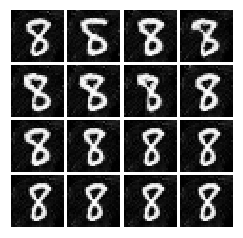

Modified noise vector, index = 3


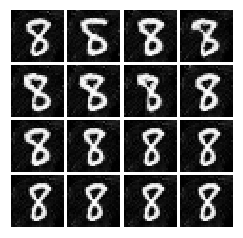

Modified noise vector, index = 4


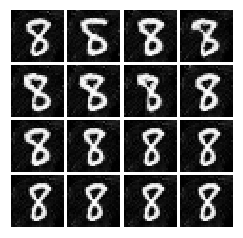

Modified noise vector, index = 5


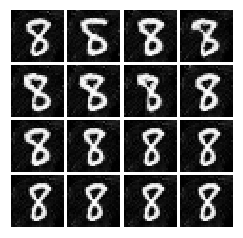

Modified noise vector, index = 6


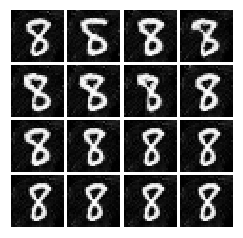

Modified noise vector, index = 7


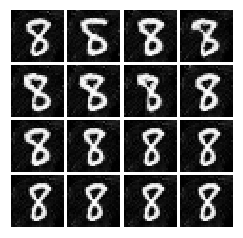

Modified noise vector, index = 8


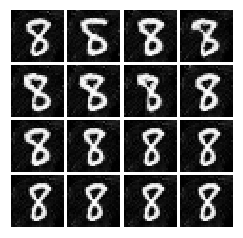

Modified noise vector, index = 9


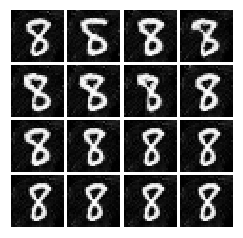

In [727]:
# Latent 
sample_size = 16
latent_discrete = 10
tf.reset_default_graph()
#z = sample_noise(batch_size, noise_dim)

npvm = np.zeros((noise_dim,batch_size, noise_dim))
samples = np.zeros((noise_dim,batch_size, 784))

npv = np.random.uniform(-1,1,(batch_size, noise_dim))
 
sr = np.random.uniform(-1,1,( noise_dim))
  
for j in range (sample_size):
    npv[j,:] = sr
 
for k in range (noise_dim):
    npvm[k] = np.copy(npv)

for h in range(latent_discrete):
    for i in range(latent_discrete):
        for p in range(latent_discrete):
            npvm[h,i,p] = 0
for h in range(latent_discrete):
    for i in range (latent_discrete):
        npvm[h,i,i] = 1
print (npvm.shape)
        
kz = tf.Variable(tf.zeros((batch_size, noise_dim), tf.float32))
# generated images
G_sample = generator(kz )
with get_session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "/tmp/model.ckpt")
    kz.load(npv, session=sess)
    samples_a = sess.run(G_sample )
    for k in range(noise_dim):
        npvm_x = np.copy(npvm[k])
        kz.load(npvm_x, session=sess)
        samples_x = sess.run(G_sample)
        samples[k,:,:] = np.copy(samples_x)
print ('Original noise vector')
fig = show_images(samples_a[:sample_size])
plt.show()

for k in range(10):
    print ('Modified noise vector, index = %d'% k)
    fig = show_images(samples[k][:sample_size])
    plt.show()
 